<a href="https://colab.research.google.com/github/minh071289/MachineLearning/blob/main/uet_ml_character_level_language_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import tqdm

# RNN

In [2]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size):
        super(RNN, self).__init__()
        self.input_embed = nn.Embedding(vocab_size, input_size)
        self.vocab_size = vocab_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.xh = nn.Linear(input_size, hidden_size)
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.hy = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        """
        x: (length, batch_size, input_size)
        h: (batch_size, hidden_size)
        """
        hs = []
        for i in range(x.shape[0]):
            xi = self.input_embed(x[i])
            h = torch.tanh(torch.tanh(self.xh(xi)) + torch.tanh(self.hh(h)))
            hs.append(h)
        h = torch.cat(hs, dim=0)
        y = self.hy(h)
        return y, h

In [3]:
def train(rnn: RNN,corpus,max_length,
          n_epochs,batch_size,lr,
          optimizer,**optim_kwargs):
    if optimizer == 'sgd':
        optimizer = torch.optim.SGD(rnn.parameters(), lr=lr, **optim_kwargs)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(rnn.parameters(), lr=lr, **optim_kwargs)
    criterion = nn.CrossEntropyLoss(reduction='mean')

    rnn.to('cuda')
    corpus = corpus.to('cuda')

    losses = []
    epoch_tqdm = tqdm.trange(n_epochs) # progress bar

    # slide through the corpus to generate batches of size (max_length × batch_size).
    for ei in epoch_tqdm:
        for i in range(len(corpus) - max_length * batch_size):
            optimizer.zero_grad()

            # x is input, y is the expected next token target
            x = corpus[i:i + max_length * batch_size].view(max_length, batch_size, -1)
            y = corpus[i + 1:i + max_length * batch_size + 1].view(max_length, batch_size, -1)

            # initialize hidden state h0 to zeros
            h0 = torch.zeros(1, rnn.hidden_size).to('cuda')
            # compute predicted output from z and h0
            y_hat, _ = rnn(x, h0)

            # compute cross-entropy loss
            loss = criterion(y_hat.view(max_length * batch_size,
                                        rnn.output_size),
                             y.view(max_length * batch_size)) # reshape to 2-d tensors
            # back-propagation
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        epoch_tqdm.set_description(f"Loss: {loss.item():.4f}")
    return rnn, losses

In [21]:
#@title Corpus
corpus = """The Tragedy of Othello, the Moor of Venice
Dramatis Personae
DUKE OF VENICE
BRABANTIO, a senator.
Other Senators.
GRATIANO, brother to Brabantio.
LODOVICO, kinsman to Brabantio.
OTHELLO, a noble Moor in the service of the Venetian state.
CASSIO, his lieutenant.
IAGO, his ancient.
RODERIGO, a Venetian gentleman.
MONTANO, Othello's predecessor in the government of Cyprus.
Clown, servant to Othello.
DESDEMONA, daughter to Brabantio and wife to Othello.
EMILIA, wife to Iago.
BIANCA, mistress to Cassio.
Sailor, Messenger, Herald, Officers, Gentlemen, Musicians, and Attendants.
SCENE Venice: a Sea-port in Cyprus. OTHELLO
ACT I
SCENE I. Venice. A street.
Enter RODERIGO and IAGO
RODERIGO
Tush! never tell me; I take it much unkindly That thou, Iago, who hast had my purse As if the strings were thine, shouldst know of this.
IAGO
'Sblood, but you will not hear me: If ever I did dream of such a matter, Abhor me.
RODERIGO
Thou told'st me thou didst hold him in thy hate.
IAGO
Despise me, if I do not. Three great ones of the city, In personal suit to make me his lieutenant, Off-capp'd to him: and, by the faith of man, I know my price, I am worth no worse a place: But he; as loving his own pride and purposes, Evades them, with a bombast circumstance Horribly stuff'd with epithets of war; And, in conclusion, Nonsuits my mediators; for, 'Certes,' says he, 'I have already chose my officer.' And what was he? Forsooth, a great arithmetician, One Michael Cassio, a Florentine, A fellow almost damn'd in a fair wife; That never set a squadron in the field, Nor the division of a battle knows More than a spinster; unless the bookish theoric, Wherein the toged consuls can propose As masterly as he: mere prattle, without practise, Is all his soldiership. But he, sir, had the election: And I, of whom his eyes had seen the proof At Rhodes, at Cyprus and on other grounds Christian and heathen, must be be-lee'd and calm'd By debitor and creditor: this counter-caster, He, in good time, must his lieutenant be, And I--God bless the mark!--his Moorship's ancient.
RODERIGO
By heaven, I rather would have been his hangman.
IAGO
Why, there's no remedy; 'tis the curse of service, Preferment goes by letter and affection, And not by old gradation, where each second Stood heir to the first. Now, sir, be judge yourself, Whether I in any just term am affined To love the Moor.
RODERIGO
I would not follow him then.
IAGO
O, sir, content you; I follow him to serve my turn upon him: We cannot all be masters, nor all masters Cannot be truly follow'd. You shall mark Many a duteous and knee-crooking knave, That, doting on his own obsequious bondage, Wears out his time, much like his master's ass, For nought but provender, and when he's old, cashier'd: Whip me such honest knaves. Others there are Who, trimm'd in forms and visages of duty, Keep yet their hearts attending on themselves, And, throwing but shows of service on their lords, Do well thrive by them and when they have lined their coats Do themselves homage: these fellows have some soul; And such a one do I profess myself. For, sir, It is as sure as you are Roderigo, Were I the Moor, I would not be Iago: In following him, I follow but myself; Heaven is my judge, not I for love and duty, But seeming so, for my peculiar end: For when my outward action doth demonstrate The native act and figure of my heart In compliment extern, 'tis not long after But I will wear my heart upon my sleeve For daws to peck at: I am not what I am.
RODERIGO
What a full fortune does the thicklips owe If he can carry't thus!
IAGO
Call up her father, Rouse him: make after him, poison his delight, Proclaim him in the streets; incense her kinsmen, And, though he in a fertile climate dwell, Plague him with flies: though that his joy be joy, Yet throw such changes of vexation on't, As it may lose some colour.
RODERIGO
Here is her father's house; I'll call aloud.
IAGO
Do, with like timorous accent and dire yell As when, by night and negligence, the fire Is spied in populous cities.
RODERIGO
What, ho, Brabantio! Signior Brabantio, ho!
IAGO
Awake! what, ho, Brabantio! thieves! thieves! thieves! Look to your house, your daughter and your bags! Thieves! thieves! BRABANTIO appears above, at a window
BRABANTIO
What is the reason of this terrible summons? What is the matter there?
RODERIGO
Signior, is all your family within?
IAGO
Are your doors lock'd?
BRABANTIO
Why, wherefore ask you this?
IAGO
'Zounds, sir, you're robb'd; for shame, put on your gown; Your heart is burst, you have lost half your soul; Even now, now, very now, an old black ram Is topping your white ewe. Arise, arise; Awake the snorting citizens with the bell, Or else the devil will make a grandsire of you: Arise, I say.
BRABANTIO
What, have you lost your wits?
RODERIGO
Most reverend signior, do you know my voice?
BRABANTIO
Not I what are you?
RODERIGO
My name is Roderigo.
BRABANTIO
The worser welcome: I have charged thee not to haunt about my doors: In honest plainness thou hast heard me say My daughter is not for thee; and now, in madness, Being full of supper and distempering draughts, Upon malicious bravery, dost thou come To start my quiet.
RODERIGO
Sir, sir, sir,--
BRABANTIO
But thou must needs be sure My spirit and my place have in them power To make this bitter to thee.
RODERIGO
Patience, good sir.
BRABANTIO
What tell'st thou me of robbing? this is Venice; My house is not a grange.
RODERIGO
Most grave Brabantio, In simple and pure soul I come to you.
IAGO
'Zounds, sir, you are one of those that will not serve God, if the devil bid you. Because we come to do you service and you think we are ruffians, you'll have your daughter covered with a Barbary horse; you'll have your nephews neigh to you; you'll have coursers for cousins and gennets for germans.
BRABANTIO
What profane wretch art thou?
IAGO
I am one, sir, that comes to tell you your daughter and the Moor are now making the beast with two backs.
BRABANTIO
Thou art a villain.
IAGO
You are--a senator.
BRABANTIO
This thou shalt answer; I know thee, Roderigo.
RODERIGO
Sir, I will answer any thing. But, I beseech you, If't be your pleasure and most wise consent, As partly I find it is, that your fair daughter, At this odd-even and dull watch o' the night, Transported, with no worse nor better guard But with a knave of common hire, a gondolier, To the gross clasps of a lascivious Moor-- If this be known to you and your allowance, We then have done you bold and saucy wrongs; But if you know not this, my manners tell me We have your wrong rebuke. Do not believe That, from the sense of all civility, I thus would play and trifle with your reverence: Your daughter, if you have not given her leave, I say again, hath made a gross revolt; Tying her duty, beauty, wit and fortunes In an extravagant and wheeling stranger Of here and every where. Straight satisfy yourself: If she be in her chamber or your house, Let loose on me the justice of the state For thus deluding you.
BRABANTIO
Strike on the tinder, ho! Give me a taper! call up all my people! This accident is not unlike my dream: Belief of it oppresses me already. Light, I say! light! Exit above
IAGO
Farewell; for I must leave you: It seems not meet, nor wholesome to my place, To be produced--as, if I stay, I shall-- Against the Moor: for, I do know, the state, However this may gall him with some cheque, Cannot with safety cast him, for he's embark'd With such loud reason to the Cyprus wars, Which even now stand in act, that, for their souls, Another of his fathom they have none, To lead their business: in which regard, Though I do hate him as I do hell-pains. Yet, for necessity of present life, I must show out a flag and sign of love, Which is indeed but sign. That you shall surely find him, Lead to the Sagittary the raised search; And there will I be with him. So, farewell. Exit Enter, below, BRABANTIO, and Servants with torches
BRABANTIO
It is too true an evil: gone she is; And what's to come of my despised time Is nought but bitterness. Now, Roderigo, Where didst thou see her? O unhappy girl! With the Moor, say'st thou? Who would be a father! How didst thou know 'twas she? O she deceives me Past thought! What said she to you? Get more tapers: Raise all my kindred. Are they married, think you?
RODERIGO
Truly, I think they are.
BRABANTIO
O heaven! How got she out? O treason of the blood! Fathers, from hence trust not your daughters' minds By what you see them act. Is there not charms By which the property of youth and maidhood May be abused? Have you not read, Roderigo, Of some such thing?
RODERIGO
Yes, sir, I have indeed.
BRABANTIO
Call up my brother. O, would you had had her! Some one way, some another. Do you know Where we may apprehend her and the Moor?
RODERIGO
I think I can discover him, if you please, To get good guard and go along with me.
BRABANTIO
Pray you, lead on. At every house I'll call; I may command at most. Get weapons, ho! And raise some special officers of night. On, good Roderigo: I'll deserve your pains. Exeunt
SCENE II. Another street.
Enter OTHELLO, IAGO, and Attendants with torches
IAGO
Though in the trade of war I have slain men, Yet do I hold it very stuff o' the conscience To do no contrived murder: I lack iniquity Sometimes to do me service: nine or ten times I had thought to have yerk'd him here under the ribs.
OTHELLO
'Tis better as it is.
IAGO
Nay, but he prated, And spoke such scurvy and provoking terms Against your honour That, with the little godliness I have, I did full hard forbear him. But, I pray you, sir, Are you fast married? Be assured of this, That the magnifico is much beloved, And hath in his effect a voice potential As double as the duke's: he will divorce you; Or put upon you what restraint and grievance The law, with all his might to enforce it on, Will give him cable.
OTHELLO
Let him do his spite: My services which I have done the signiory Shall out-tongue his complaints. 'Tis yet to know,-- Which, when I know that boasting is an honour, I shall promulgate--I fetch my life and being From men of royal siege, and my demerits May speak unbonneted to as proud a fortune As this that I have reach'd: for know, Iago, But that I love the gentle Desdemona, I would not my unhoused free condition Put into circumscription and confine For the sea's worth. But, look! what lights come yond?
IAGO
Those are the raised father and his friends: You were best go in.
OTHELLO
Not I I must be found: My parts, my title and my perfect soul Shall manifest me rightly. Is it they?
IAGO
By Janus, I think no. Enter CASSIO, and certain Officers with torches
OTHELLO
The servants of the duke, and my lieutenant. The goodness of the night upon you, friends! What is the news?
CASSIO
The duke does greet you, general, And he requires your haste-post-haste appearance, Even on the instant.
OTHELLO
What is the matter, think you?
CASSIO
Something from Cyprus as I may divine: It is a business of some heat: the galleys Have sent a dozen sequent messengers This very night at one another's heels, And many of the consuls, raised and met, Are at the duke's already: you have been hotly call'd for; When, being not at your lodging to be found, The senate hath sent about three several guests To search you out.
OTHELLO
'Tis well I am found by you. I will but spend a word here in the house, And go with you. Exit
CASSIO
Ancient, what makes he here?
IAGO
'Faith, he to-night hath boarded a land carack: If it prove lawful prize, he's made for ever.
CASSIO
I do not understand.
IAGO
He's married.
CASSIO
To who? Re-enter OTHELLO
IAGO
Marry, to--Come, captain, will you go?
OTHELLO
Have with you.
CASSIO
Here comes another troop to seek for you.
IAGO
It is Brabantio. General, be advised; He comes to bad intent. Enter BRABANTIO, RODERIGO, and Officers with torches and weapons
OTHELLO
Holla! stand there!
RODERIGO
Signior, it is the Moor.
BRABANTIO
Down with him, thief! They draw on both sides
IAGO
You, Roderigo! come, sir, I am for you.
OTHELLO
Keep up your bright swords, for the dew will rust them. Good signior, you shall more command with years Than with your weapons.
BRABANTIO
O thou foul thief, where hast thou stow'd my daughter? Damn'd as thou art, thou hast enchanted her; For I'll refer me to all things of sense, If she in chains of magic were not bound, Whether a maid so tender, fair and happy, So opposite to marriage that she shunned The wealthy curled darlings of our nation, Would ever have, to incur a general mock, Run from her guardage to the sooty bosom Of such a thing as thou, to fear, not to delight. Judge me the world, if 'tis not gross in sense That thou hast practised on her with foul charms, Abused her delicate youth with drugs or minerals That weaken motion: I'll have't disputed on; 'Tis probable and palpable to thinking. I therefore apprehend and do attach thee For an abuser of the world, a practiser Of arts inhibited and out of warrant. Lay hold upon him: if he do resist, Subdue him at his peril.
OTHELLO
Hold your hands, Both you of my inclining, and the rest: Were it my cue to fight, I should have known it Without a prompter. Where will you that I go To answer this your charge?
BRABANTIO
To prison, till fit time Of law and course of direct session Call thee to answer.
OTHELLO
What if I do obey? How may the duke be therewith satisfied, Whose messengers are here about my side, Upon some present business of the state To bring me to him?
First Officer
'Tis true, most worthy signior; The duke's in council and your noble self, I am sure, is sent for.
BRABANTIO
How! the duke in council! In this time of the night! Bring him away: Mine's not an idle cause: the duke himself, Or any of my brothers of the state, Cannot but feel this wrong as 'twere their own; For if such actions may have passage free, Bond-slaves and pagans shall our statesmen be. Exeunt
SCENE III. A council-chamber.
The DUKE and Senators sitting at a table; Officers attending
DUKE OF VENICE
There is no composition in these news That gives them credit.
First Senator
Indeed, they are disproportion'd; My letters say a hundred and seven galleys.
DUKE OF VENICE
And mine, a hundred and forty.
Second Senator
And mine, two hundred: But though they jump not on a just account,-- As in these cases, where the aim reports, 'Tis oft with difference--yet do they all confirm A Turkish fleet, and bearing up to Cyprus.
DUKE OF VENICE
Nay, it is possible enough to judgment: I do not so secure me in the error, But the main article I do approve In fearful sense.
Sailor
Within What, ho! what, ho! what, ho!
First Officer
A messenger from the galleys. Enter a Sailor
DUKE OF VENICE
Now, what's the business?
Sailor
The Turkish preparation makes for Rhodes; So was I bid report here to the state By Signior Angelo.
DUKE OF VENICE
How say you by this change?
First Senator
This cannot be, By no assay of reason: 'tis a pageant, To keep us in false gaze. When we consider The importancy of Cyprus to the Turk, And let ourselves again but understand, That as it more concerns the Turk than Rhodes, So may he with more facile question bear it, For that it stands not in such warlike brace, But altogether lacks the abilities That Rhodes is dress'd in: if we make thought of this, We must not think the Turk is so unskilful To leave that latest which concerns him first, Neglecting an attempt of ease and gain, To wake and wage a danger profitless.
DUKE OF VENICE
Nay, in all confidence, he's not for Rhodes.
First Officer
Here is more news. Enter a Messenger
Messenger
The Ottomites, reverend and gracious, Steering with due course towards the isle of Rhodes, Have there injointed them with an after fleet.
First Senator
Ay, so I thought. How many, as you guess?
Messenger
Of thirty sail: and now they do restem Their backward course, bearing with frank appearance Their purposes toward Cyprus. Signior Montano, Your trusty and most valiant servitor, With his free duty recommends you thus, And prays you to believe him.
DUKE OF VENICE
'Tis certain, then, for Cyprus. Marcus Luccicos, is not he in town?
First Senator
He's now in Florence.
DUKE OF VENICE
Write from us to him; post-post-haste dispatch.
First Senator
Here comes Brabantio and the valiant Moor. Enter BRABANTIO, OTHELLO, IAGO, RODERIGO, and Officers
DUKE OF VENICE
Valiant Othello, we must straight employ you Against the general enemy Ottoman. To BRABANTIO I did not see you; welcome, gentle signior; We lack'd your counsel and your help tonight.
BRABANTIO
So did I yours. Good your grace, pardon me; Neither my place nor aught I heard of business Hath raised me from my bed, nor doth the general care Take hold on me, for my particular grief Is of so flood-gate and o'erbearing nature That it engluts and swallows other sorrows And it is still itself.
DUKE OF VENICE
Why, what's the matter?
BRABANTIO
My daughter! O, my daughter!
DUKE OF VENICE
Senator
Dead?
BRABANTIO
Ay, to me; She is abused, stol'n from me, and corrupted By spells and medicines bought of mountebanks; For nature so preposterously to err, Being not deficient, blind, or lame of sense, Sans witchcraft could not.
DUKE OF VENICE
Whoe'er he be that in this foul proceeding Hath thus beguiled your daughter of herself And you of her, the bloody book of law You shall yourself read in the bitter letter After your own sense, yea, though our proper son Stood in your action.
BRABANTIO
Humbly I thank your grace. Here is the man, this Moor, whom now, it seems, Your special mandate for the state-affairs Hath hither brought.
DUKE OF VENICE
Senator
We are very sorry for't.
DUKE OF VENICE
To OTHELLO What, in your own part, can you say to this?
BRABANTIO
Nothing, but this is so.
OTHELLO
Most potent, grave, and reverend signiors, My very noble and approved good masters, That I have ta'en away this old man's daughter, It is most true; true, I have married her: The very head and front of my offending Hath this extent, no more. Rude am I in my speech, And little bless'd with the soft phrase of peace: For since these arms of mine had seven years' pith, Till now some nine moons wasted, they have used Their dearest action in the tented field, And little of this great world can I speak, More than pertains to feats of broil and battle, And therefore little shall I grace my cause In speaking for myself. Yet, by your gracious patience, I will a round unvarnish'd tale deliver Of my whole course of love; what drugs, what charms, What conjuration and what mighty magic, For such proceeding I am charged withal, I won his daughter.
BRABANTIO
A maiden never bold; Of spirit so still and quiet, that her motion Blush'd at herself; and she, in spite of nature, Of years, of country, credit, every thing, To fall in love with what she fear'd to look on! It is a judgment maim'd and most imperfect That will confess perfection so could err Against all rules of nature, and must be driven To find out practises of cunning hell, Why this should be. I therefore vouch again That with some mixtures powerful o'er the blood, Or with some dram conjured to this effect, He wrought upon her.
DUKE OF VENICE
To vouch this, is no proof, Without more wider and more overt test Than these thin habits and poor likelihoods Of modern seeming do prefer against him.
First Senator
But, Othello, speak: Did you by indirect and forced courses Subdue and poison this young maid's affections? Or came it by request and such fair question As soul to soul affordeth?
OTHELLO
I do beseech you, Send for the lady to the Sagittary, And let her speak of me before her father: If you do find me foul in her report, The trust, the office I do hold of you, Not only take away, but let your sentence Even fall upon my life.
DUKE OF VENICE
Fetch Desdemona hither.
OTHELLO
Ancient, conduct them: you best know the place. Exeunt IAGO and Attendants And, till she come, as truly as to heaven I do confess the vices of my blood, So justly to your grave ears I'll present How I did thrive in this fair lady's love, And she in mine.
DUKE OF VENICE
Say it, Othello.
OTHELLO
Her father loved me; oft invited me; Still question'd me the story of my life, From year to year, the battles, sieges, fortunes, That I have passed. I ran it through, even from my boyish days, To the very moment that he bade me tell it; Wherein I spake of most disastrous chances, Of moving accidents by flood and field Of hair-breadth scapes i' the imminent deadly breach, Of being taken by the insolent foe And sold to slavery, of my redemption thence And portance in my travels' history: Wherein of antres vast and deserts idle, Rough quarries, rocks and hills whose heads touch heaven It was my hint to speak,--such was the process; And of the Cannibals that each other eat, The Anthropophagi and men whose heads Do grow beneath their shoulders. This to hear Would Desdemona seriously incline: But still the house-affairs would draw her thence: Which ever as she could with haste dispatch, She'ld come again, and with a greedy ear Devour up my discourse: which I observing, Took once a pliant hour, and found good means To draw from her a prayer of earnest heart That I would all my pilgrimage dilate, Whereof by parcels she had something heard, But not intentively: I did consent, And often did beguile her of her tears, When I did speak of some distressful stroke That my youth suffer'd. My story being done, She gave me for my pains a world of sighs: She swore, in faith, twas strange, 'twas passing strange, 'Twas pitiful, 'twas wondrous pitiful: She wish'd she had not heard it, yet she wish'd That heaven had made her such a man: she thank'd me, And bade me, if I had a friend that loved her, I should but teach him how to tell my story. And that would woo her. Upon this hint I spake: She loved me for the dangers I had pass'd, And I loved her that she did pity them. This only is the witchcraft I have used: Here comes the lady; let her witness it. Enter DESDEMONA, IAGO, and Attendants
DUKE OF VENICE
I think this tale would win my daughter too. Good Brabantio, Take up this mangled matter at the best: Men do their broken weapons rather use Than their bare hands.
BRABANTIO
I pray you, hear her speak: If she confess that she was half the wooer, Destruction on my head, if my bad blame Light on the man! Come hither, gentle mistress: Do you perceive in all this noble company Where most you owe obedience?
DESDEMONA
My noble father, I do perceive here a divided duty: To you I am bound for life and education; My life and education both do learn me How to respect you; you are the lord of duty; I am hitherto your daughter: but here's my husband, And so much duty as my mother show'd To you, preferring you before her father, So much I challenge that I may profess Due to the Moor my lord.
BRABANTIO
God be wi' you! I have done. Please it your grace, on to the state-affairs: I had rather to adopt a child than get it. Come hither, Moor: I here do give thee that with all my heart Which, but thou hast already, with all my heart I would keep from thee. For your sake, jewel, I am glad at soul I have no other child: For thy escape would teach me tyranny, To hang clogs on them. I have done, my lord.
DUKE OF VENICE
Let me speak like yourself, and lay a sentence, Which, as a grise or step, may help these lovers Into your favour. When remedies are past, the griefs are ended By seeing the worst, which late on hopes depended. To mourn a mischief that is past and gone Is the next way to draw new mischief on. What cannot be preserved when fortune takes Patience her injury a mockery makes. The robb'd that smiles steals something from the thief; He robs himself that spends a bootless grief.
BRABANTIO
So let the Turk of Cyprus us beguile; We lose it not, so long as we can smile. He bears the sentence well that nothing bears But the free comfort which from thence he hears, But he bears both the sentence and the sorrow That, to pay grief, must of poor patience borrow. These sentences, to sugar, or to gall, Being strong on both sides, are equivocal: But words are words; I never yet did hear That the bruised heart was pierced through the ear. I humbly beseech you, proceed to the affairs of state.
DUKE OF VENICE
The Turk with a most mighty preparation makes for Cyprus. Othello, the fortitude of the place is best known to you; and though we have there a substitute of most allowed sufficiency, yet opinion, a sovereign mistress of effects, throws a more safer voice on you: you must therefore be content to slubber the gloss of your new fortunes with this more stubborn and boisterous expedition.
OTHELLO
The tyrant custom, most grave senators, Hath made the flinty and steel couch of war My thrice-driven bed of down: I do agnise A natural and prompt alacrity I find in hardness, and do undertake These present wars against the Ottomites. Most humbly therefore bending to your state, I crave fit disposition for my wife. Due reference of place and exhibition, With such accommodation and besort As levels with her breeding.
DUKE OF VENICE
If you please, Be't at her father's.
BRABANTIO
I'll not have it so.
OTHELLO
Nor I.
DESDEMONA
Nor I; I would not there reside, To put my father in impatient thoughts By being in his eye. Most gracious duke, To my unfolding lend your prosperous ear; And let me find a charter in your voice, To assist my simpleness.
DUKE OF VENICE
What would You, Desdemona?
DESDEMONA
That I did love the Moor to live with him, My downright violence and storm of fortunes May trumpet to the world: my heart's subdued Even to the very quality of my lord: I saw Othello's visage in his mind, And to his honour and his valiant parts Did I my soul and fortunes consecrate. So that, dear lords, if I be left behind, A moth of peace, and he go to the war, The rites for which I love him are bereft me, And I a heavy interim shall support By his dear absence. Let me go with him.
OTHELLO
Let her have your voices. Vouch with me, heaven, I therefore beg it not, To please the palate of my appetite, Nor to comply with heat--the young affects In me defunct--and proper satisfaction. But to be free and bounteous to her mind: And heaven defend your good souls, that you think I will your serious and great business scant For she is with me: no, when light-wing'd toys Of feather'd Cupid seal with wanton dullness My speculative and officed instruments, That my disports corrupt and taint my business, Let housewives make a skillet of my helm, And all indign and base adversities Make head against my estimation!
DUKE OF VENICE
Be it as you shall privately determine, Either for her stay or going: the affair cries haste, And speed must answer it.
First Senator
You must away to-night.
OTHELLO
With all my heart.
DUKE OF VENICE
At nine i' the morning here we'll meet again. Othello, leave some officer behind, And he shall our commission bring to you; With such things else of quality and respect As doth import you.
OTHELLO
So please your grace, my ancient; A man he is of honest and trust: To his conveyance I assign my wife, With what else needful your good grace shall think To be sent after me.
DUKE OF VENICE
Let it be so. Good night to every one. To BRABANTIO And, noble signior, If virtue no delighted beauty lack, Your son-in-law is far more fair than black.
First Senator
Adieu, brave Moor, use Desdemona well.
BRABANTIO
Look to her, Moor, if thou hast eyes to see: She has deceived her father, and may thee. Exeunt DUKE OF VENICE, Senators, Officers, &c
OTHELLO
My life upon her faith! Honest Iago, My Desdemona must I leave to thee: I prithee, let thy wife attend on her: And bring them after in the best advantage. Come, Desdemona: I have but an hour Of love, of worldly matters and direction, To spend with thee: we must obey the time. Exeunt OTHELLO and DESDEMONA
RODERIGO
Iago,--
IAGO
What say'st thou, noble heart?
RODERIGO
What will I do, thinkest thou?
IAGO
Why, go to bed, and sleep.
RODERIGO
I will incontinently drown myself.
IAGO
If thou dost, I shall never love thee after. Why, thou silly gentleman!
RODERIGO
It is silliness to live when to live is torment; and then have we a prescription to die when death is our physician.
IAGO
O villainous! I have looked upon the world for four times seven years; and since I could distinguish betwixt a benefit and an injury, I never found man that knew how to love himself. Ere I would say, I would drown myself for the love of a guinea-hen, I would change my humanity with a baboon.
RODERIGO
What should I do? I confess it is my shame to be so fond; but it is not in my virtue to amend it.
IAGO
Virtue! a fig! 'tis in ourselves that we are thus or thus. Our bodies are our gardens, to the which our wills are gardeners: so that if we will plant nettles, or sow lettuce, set hyssop and weed up thyme, supply it with one gender of herbs, or distract it with many, either to have it sterile with idleness, or manured with industry, why, the power and corrigible authority of this lies in our wills. If the balance of our lives had not one scale of reason to poise another of sensuality, the blood and baseness of our natures would conduct us to most preposterous conclusions: but we have reason to cool our raging motions, our carnal stings, our unbitted lusts, whereof I take this that you call love to be a sect or scion.
RODERIGO
It cannot be.
IAGO
It is merely a lust of the blood and a permission of the will. Come, be a man. Drown thyself! drown cats and blind puppies. I have professed me thy friend and I confess me knit to thy deserving with cables of perdurable toughness; I could never better stead thee than now. Put money in thy purse; follow thou the wars; defeat thy favour with an usurped beard; I say, put money in thy purse. It cannot be that Desdemona should long continue her love to the Moor,-- put money in thy purse,--nor he his to her: it was a violent commencement, and thou shalt see an answerable sequestration:--put but money in thy purse. These Moors are changeable in their wills: fill thy purse with money:--the food that to him now is as luscious as locusts, shall be to him shortly as bitter as coloquintida. She must change for youth: when she is sated with his body, she will find the error of her choice: she must have change, she must: therefore put money in thy purse. If thou wilt needs damn thyself, do it a more delicate way than drowning. Make all the money thou canst: if sanctimony and a frail vow betwixt an erring barbarian and a supersubtle Venetian not too hard for my wits and all the tribe of hell, thou shalt enjoy her; therefore make money. A pox of drowning thyself! it is clean out of the way: seek thou rather to be hanged in compassing thy joy than to be drowned and go without her.
RODERIGO
Wilt thou be fast to my hopes, if I depend on the issue?
IAGO
Thou art sure of me:--go, make money:--I have told thee often, and I re-tell thee again and again, I hate the Moor: my cause is hearted; thine hath no less reason. Let us be conjunctive in our revenge against him: if thou canst cuckold him, thou dost thyself a pleasure, me a sport. There are many events in the womb of time which will be delivered. Traverse! go, provide thy money. We will have more of this to-morrow. Adieu.
RODERIGO
Where shall we meet i' the morning?
IAGO
At my lodging.
RODERIGO
I'll be with thee betimes.
IAGO
Go to; farewell. Do you hear, Roderigo?
RODERIGO
What say you?
IAGO
No more of drowning, do you hear?
RODERIGO
I am changed: I'll go sell all my land. Exit
IAGO
Thus do I ever make my fool my purse: For I mine own gain'd knowledge should profane, If I would time expend with such a snipe. But for my sport and profit. I hate the Moor: And it is thought abroad, that 'twixt my sheets He has done my office: I know not if't be true; But I, for mere suspicion in that kind, Will do as if for surety. He holds me well; The better shall my purpose work on him. Cassio's a proper man: let me see now: To get his place and to plume up my will In double knavery--How, how? Let's see:-- After some time, to abuse Othello's ear That he is too familiar with his wife. He hath a person and a smooth dispose To be suspected, framed to make women false. The Moor is of a free and open nature, That thinks men honest that but seem to be so, And will as tenderly be led by the nose As asses are. I have't. It is engender'd. Hell and night Must bring this monstrous birth to the world's light. Exit
ACT II
SCENE I. A Sea-port in Cyprus. An open place near the quay.
Enter MONTANO and two Gentlemen
MONTANO
What from the cape can you discern at sea?
First Gentleman
Nothing at all: it is a highwrought flood; I cannot, 'twixt the heaven and the main, Descry a sail.
MONTANO
Methinks the wind hath spoke aloud at land; A fuller blast ne'er shook our battlements: If it hath ruffian'd so upon the sea, What ribs of oak, when mountains melt on them, Can hold the mortise? What shall we hear of this?
Second Gentleman
A segregation of the Turkish fleet: For do but stand upon the foaming shore, The chidden billow seems to pelt the clouds; The wind-shaked surge, with high and monstrous mane, seems to cast water on the burning bear, And quench the guards of the ever-fixed pole: I never did like molestation view On the enchafed flood.
MONTANO
If that the Turkish fleet Be not enshelter'd and embay'd, they are drown'd: It is impossible they bear it out. Enter a third Gentleman
Third Gentleman
News, lads! our wars are done. The desperate tempest hath so bang'd the Turks, That their designment halts: a noble ship of Venice Hath seen a grievous wreck and sufferance On most part of their fleet.
MONTANO
How! is this true?
Third Gentleman
The ship is here put in, A Veronesa; Michael Cassio, Lieutenant to the warlike Moor Othello, Is come on shore: the Moor himself at sea, And is in full commission here for Cyprus.
MONTANO
I am glad on't; 'tis a worthy governor.
Third Gentleman
But this same Cassio, though he speak of comfort Touching the Turkish loss, yet he looks sadly, And prays the Moor be safe; for they were parted With foul and violent tempest.
MONTANO
Pray heavens he be; For I have served him, and the man commands Like a full soldier. Let's to the seaside, ho! As well to see the vessel that's come in As to throw out our eyes for brave Othello, Even till we make the main and the aerial blue An indistinct regard.
Third Gentleman
Come, let's do so: For every minute is expectancy Of more arrivance. Enter CASSIO
CASSIO
Thanks, you the valiant of this warlike isle, That so approve the Moor! O, let the heavens Give him defence against the elements, For I have lost us him on a dangerous sea.
MONTANO
Is he well shipp'd?
CASSIO
His bark is stoutly timber'd, his pilot Of very expert and approved allowance; Therefore my hopes, not surfeited to death, Stand in bold cure. A cry within 'A sail, a sail, a sail!' Enter a fourth Gentleman
CASSIO
What noise?
Fourth Gentleman
The town is empty; on the brow o' the sea Stand ranks of people, and they cry 'A sail!'
CASSIO
My hopes do shape him for the governor. Guns heard
Second Gentlemen
They do discharge their shot of courtesy: Our friends at least.
CASSIO
I pray you, sir, go forth, And give us truth who 'tis that is arrived.
Second Gentleman
I shall. Exit
MONTANO
But, good lieutenant, is your general wived?
CASSIO
Most fortunately: he hath achieved a maid That paragons description and wild fame; One that excels the quirks of blazoning pens, And in the essential vesture of creation Does tire the ingener. Re-enter second Gentleman How now! who has put in?
Second Gentleman
'Tis one Iago, ancient to the general.
CASSIO
Has had most favourable and happy speed: Tempests themselves, high seas, and howling winds, The gutter'd rocks and congregated sands-- Traitors ensteep'd to clog the guiltless keel,-- As having sense of beauty, do omit Their mortal natures, letting go safely by The divine Desdemona.
MONTANO
What is she?
CASSIO
She that I spake of, our great captain's captain, Left in the conduct of the bold Iago, Whose footing here anticipates our thoughts A se'nnight's speed. Great Jove, Othello guard, And swell his sail with thine own powerful breath, That he may bless this bay with his tall ship, Make love's quick pants in Desdemona's arms, Give renew'd fire to our extincted spirits And bring all Cyprus comfort! Enter DESDEMONA, EMILIA, IAGO, RODERIGO, and Attendants O, behold, The riches of the ship is come on shore! Ye men of Cyprus, let her have your knees. Hail to thee, lady! and the grace of heaven, Before, behind thee, and on every hand, Enwheel thee round!
DESDEMONA
I thank you, valiant Cassio. What tidings can you tell me of my lord?
CASSIO
He is not yet arrived: nor know I aught But that he's well and will be shortly here.
DESDEMONA
O, but I fear--How lost you company?
CASSIO
The great contention of the sea and skies Parted our fellowship--But, hark! a sail. Within 'A sail, a sail!' Guns heard
Second Gentleman
They give their greeting to the citadel; This likewise is a friend.
CASSIO
See for the news. Exit Gentleman Good ancient, you are welcome. To EMILIA Welcome, mistress. Let it not gall your patience, good Iago, That I extend my manners; 'tis my breeding That gives me this bold show of courtesy. Kissing her
IAGO
Sir, would she give you so much of her lips As of her tongue she oft bestows on me, You'll have enough.
DESDEMONA
Alas, she has no speech.
IAGO
In faith, too much; I find it still, when I have list to sleep: Marry, before your ladyship, I grant, She puts her tongue a little in her heart, And chides with thinking.
EMILIA
You have little cause to say so.
IAGO
Come on, come on; you are pictures out of doors, Bells in your parlors, wild-cats in your kitchens, Saints m your injuries, devils being offended, Players in your housewifery, and housewives' in your beds.
DESDEMONA
O, fie upon thee, slanderer!
IAGO
Nay, it is true, or else I am a Turk: You rise to play and go to bed to work.
EMILIA
You shall not write my praise.
IAGO
No, let me not.
DESDEMONA
What wouldst thou write of me, if thou shouldst praise me?
IAGO
O gentle lady, do not put me to't; For I am nothing, if not critical.
DESDEMONA
Come on assay. There's one gone to the harbour?
IAGO
Ay, madam.
DESDEMONA
I am not merry; but I do beguile The thing I am, by seeming otherwise. Come, how wouldst thou praise me?
IAGO
I am about it; but indeed my invention Comes from my pate as birdlime does from frize; It plucks out brains and all: but my Muse labours, And thus she is deliver'd. If she be fair and wise, fairness and wit, The one's for use, the other useth it.
DESDEMONA
Well praised! How if she be black and witty?
IAGO
If she be black, and thereto have a wit, She'll find a white that shall her blackness fit.
DESDEMONA
Worse and worse.
EMILIA
How if fair and foolish?
IAGO
She never yet was foolish that was fair; For even her folly help'd her to an heir.
DESDEMONA
These are old fond paradoxes to make fools laugh i' the alehouse. What miserable praise hast thou for her that's foul and foolish?
IAGO
There's none so foul and foolish thereunto, But does foul pranks which fair and wise ones do.
DESDEMONA
O heavy ignorance! thou praisest the worst best. But what praise couldst thou bestow on a deserving woman indeed, one that, in the authority of her merit, did justly put on the vouch of very malice itself?
IAGO
She that was ever fair and never proud, Had tongue at will and yet was never loud, Never lack'd gold and yet went never gay, Fled from her wish and yet said 'Now I may,' She that being anger'd, her revenge being nigh, Bade her wrong stay and her displeasure fly, She that in wisdom never was so frail To change the cod's head for the salmon's tail; She that could think and ne'er disclose her mind, See suitors following and not look behind, She was a wight, if ever such wight were,--
DESDEMONA
To do what?
IAGO
To suckle fools and chronicle small beer.
DESDEMONA
O most lame and impotent conclusion! Do not learn of him, Emilia, though he be thy husband. How say you, Cassio? is he not a most profane and liberal counsellor?
CASSIO
He speaks home, madam: You may relish him more in the soldier than in the scholar.
IAGO
Aside He takes her by the palm: ay, well said, whisper: with as little a web as this will I ensnare as great a fly as Cassio. Ay, smile upon her, do; I will gyve thee in thine own courtship. You say true; 'tis so, indeed: if such tricks as these strip you out of your lieutenantry, it had been better you had not kissed your three fingers so oft, which now again you are most apt to play the sir in. Very good; well kissed! an excellent courtesy! 'tis so, indeed. Yet again your fingers to your lips? would they were clyster-pipes for your sake! Trumpet within The Moor! I know his trumpet.
CASSIO
'Tis truly so.
DESDEMONA
Let's meet him and receive him.
CASSIO
Lo, where he comes! Enter OTHELLO and Attendants
OTHELLO
O my fair warrior!
DESDEMONA
My dear Othello!
OTHELLO
It gives me wonder great as my content To see you here before me. O my soul's joy! If after every tempest come such calms, May the winds blow till they have waken'd death! And let the labouring bark climb hills of seas Olympus-high and duck again as low As hell's from heaven! If it were now to die, 'Twere now to be most happy; for, I fear, My soul hath her content so absolute That not another comfort like to this Succeeds in unknown fate.
DESDEMONA
The heavens forbid But that our loves and comforts should increase, Even as our days do grow!
OTHELLO
Amen to that, sweet powers! I cannot speak enough of this content; It stops me here; it is too much of joy: And this, and this, the greatest discords be Kissing her That e'er our hearts shall make!
IAGO
Aside O, you are well tuned now! But I'll set down the pegs that make this music, As honest as I am.
OTHELLO
Come, let us to the castle. News, friends; our wars are done, the Turks are drown'd. How does my old acquaintance of this isle? Honey, you shall be well desired in Cyprus; I have found great love amongst them. O my sweet, I prattle out of fashion, and I dote In mine own comforts. I prithee, good Iago, Go to the bay and disembark my coffers: Bring thou the master to the citadel; He is a good one, and his worthiness Does challenge much respect. Come, Desdemona, Once more, well met at Cyprus. Exeunt OTHELLO, DESDEMONA, and Attendants
IAGO
Do thou meet me presently at the harbour. Come hither. If thou be'st valiant,-- as, they say, base men being in love have then a nobility in their natures more than is native to them--list me. The lieutenant tonight watches on the court of guard:--first, I must tell thee this--Desdemona is directly in love with him.
RODERIGO
With him! why, 'tis not possible.
IAGO
Lay thy finger thus, and let thy soul be instructed. Mark me with what violence she first loved the Moor, but for bragging and telling her fantastical lies: and will she love him still for prating? let not thy discreet heart think it. Her eye must be fed; and what delight shall she have to look on the devil? When the blood is made dull with the act of sport, there should be, again to inflame it and to give satiety a fresh appetite, loveliness in favour, sympathy in years, manners and beauties; all which the Moor is defective in: now, for want of these required conveniences, her delicate tenderness will find itself abused, begin to heave the gorge, disrelish and abhor the Moor; very nature will instruct her in it and compel her to some second choice. Now, sir, this granted,--as it is a most pregnant and unforced position--who stands so eminent in the degree of this fortune as Cassio does? a knave very voluble; no further conscionable than in putting on the mere form of civil and humane seeming, for the better compassing of his salt and most hidden loose affection? why, none; why, none: a slipper and subtle knave, a finder of occasions, that has an eye can stamp and counterfeit advantages, though true advantage never present itself; a devilish knave. Besides, the knave is handsome, young, and hath all those requisites in him that folly and green minds look after: a pestilent complete knave; and the woman hath found him already.
RODERIGO
I cannot believe that in her; she's full of most blessed condition.
IAGO
Blessed fig's-end! the wine she drinks is made of grapes: if she had been blessed, she would never have loved the Moor. Blessed pudding! Didst thou not see her paddle with the palm of his hand? didst not mark that?
RODERIGO
Yes, that I did; but that was but courtesy.
IAGO
Lechery, by this hand; an index and obscure prologue to the history of lust and foul thoughts. They met so near with their lips that their breaths embraced together. Villanous thoughts, Roderigo! when these mutualities so marshal the way, hard at hand comes the master and main exercise, the incorporate conclusion, Pish! But, sir, be you ruled by me: I have brought you from Venice. Watch you to-night; for the command, I'll lay't upon you. Cassio knows you not. I'll not be far from you: do you find some occasion to anger Cassio, either by speaking too loud, or tainting his discipline; or from what other course you please, which the time shall more favourably minister.
RODERIGO
Well.
IAGO
Sir, he is rash and very sudden in choler, and haply may strike at you: provoke him, that he may; for even out of that will I cause these of Cyprus to mutiny; whose qualification shall come into no true taste again but by the displanting of Cassio. So shall you have a shorter journey to your desires by the means I shall then have to prefer them; and the impediment most profitably removed, without the which there were no expectation of our prosperity.
RODERIGO
I will do this, if I can bring it to any opportunity.
IAGO
I warrant thee. Meet me by and by at the citadel: I must fetch his necessaries ashore. Farewell.
RODERIGO
Adieu. Exit
IAGO
That Cassio loves her, I do well believe it; That she loves him, 'tis apt and of great credit: The Moor, howbeit that I endure him not, Is of a constant, loving, noble nature, And I dare think he'll prove to Desdemona A most dear husband. Now, I do love her too; Not out of absolute lust, though peradventure I stand accountant for as great a sin, But partly led to diet my revenge, For that I do suspect the lusty Moor Hath leap'd into my seat; the thought whereof Doth, like a poisonous mineral, gnaw my inwards; And nothing can or shall content my soul Till I am even'd with him, wife for wife, Or failing so, yet that I put the Moor At least into a jealousy so strong That judgment cannot cure. Which thing to do, If this poor trash of Venice, whom I trash For his quick hunting, stand the putting on, I'll have our Michael Cassio on the hip, Abuse him to the Moor in the rank garb-- For I fear Cassio with my night-cap too-- Make the Moor thank me, love me and reward me. For making him egregiously an ass And practising upon his peace and quiet Even to madness. 'Tis here, but yet confused: Knavery's plain face is never seen tin used. Exit
SCENE II. A street.
Enter a Herald with a proclamation; People following
Herald
It is Othello's pleasure, our noble and valiant general, that, upon certain tidings now arrived, importing the mere perdition of the Turkish fleet, every man put himself into triumph; some to dance, some to make bonfires, each man to what sport and revels his addiction leads him: for, besides these beneficial news, it is the celebration of his nuptial. So much was his pleasure should be proclaimed. All offices are open, and there is full liberty of feasting from this present hour of five till the bell have told eleven. Heaven bless the isle of Cyprus and our noble general Othello! Exeunt
SCENE III. A hall in the castle.
Enter OTHELLO, DESDEMONA, CASSIO, and Attendants
OTHELLO
Good Michael, look you to the guard to-night: Let's teach ourselves that honourable stop, Not to outsport discretion.
CASSIO
Iago hath direction what to do; But, notwithstanding, with my personal eye Will I look to't.
OTHELLO
Iago is most honest. Michael, good night: to-morrow with your earliest Let me have speech with you. To DESDEMONA Come, my dear love, The purchase made, the fruits are to ensue; That profit's yet to come 'tween me and you. Good night. Exeunt OTHELLO, DESDEMONA, and Attendants Enter IAGO
CASSIO
Welcome, Iago; we must to the watch.
IAGO
Not this hour, lieutenant; 'tis not yet ten o' the clock. Our general cast us thus early for the love of his Desdemona; who let us not therefore blame: he hath not yet made wanton the night with her; and she is sport for Jove.
CASSIO
She's a most exquisite lady.
IAGO
And, I'll warrant her, fun of game.
CASSIO
Indeed, she's a most fresh and delicate creature.
IAGO
What an eye she has! methinks it sounds a parley of provocation.
CASSIO
An inviting eye; and yet methinks right modest.
IAGO
And when she speaks, is it not an alarum to love?
CASSIO
She is indeed perfection.
IAGO
Well, happiness to their sheets! Come, lieutenant, I have a stoup of wine; and here without are a brace of Cyprus gallants that would fain have a measure to the health of black Othello.
CASSIO
Not to-night, good Iago: I have very poor and unhappy brains for drinking: I could well wish courtesy would invent some other custom of entertainment.
IAGO
O, they are our friends; but one cup: I'll drink for you.
CASSIO
I have drunk but one cup to-night, and that was craftily qualified too, and, behold, what innovation it makes here: I am unfortunate in the infirmity, and dare not task my weakness with any more.
IAGO
What, man! 'tis a night of revels: the gallants desire it.
CASSIO
Where are they?
IAGO
Here at the door; I pray you, call them in.
CASSIO
I'll do't; but it dislikes me. Exit
IAGO
If I can fasten but one cup upon him, With that which he hath drunk to-night already, He'll be as full of quarrel and offence As my young mistress' dog. Now, my sick fool Roderigo, Whom love hath turn'd almost the wrong side out, To Desdemona hath to-night caroused Potations pottle-deep; and he's to watch: Three lads of Cyprus, noble swelling spirits, That hold their honours in a wary distance, The very elements of this warlike isle, Have I to-night fluster'd with flowing cups, And they watch too. Now, 'mongst this flock of drunkards, Am I to put our Cassio in some action That may offend the isle.--But here they come: If consequence do but approve my dream, My boat sails freely, both with wind and stream. Re-enter CASSIO; with him MONTANO and Gentlemen; servants following with wine
CASSIO
'Fore God, they have given me a rouse already.
MONTANO
Good faith, a little one; not past a pint, as I am a soldier.
IAGO
Some wine, ho! Sings And let me the canakin clink, clink; And let me the canakin clink A soldier's a man; A life's but a span; Why, then, let a soldier drink. Some wine, boys!
CASSIO
'Fore God, an excellent song.
IAGO
I learned it in England, where, indeed, they are most potent in potting: your Dane, your German, and your swag-bellied Hollander--Drink, ho!--are nothing to your English.
CASSIO
Is your Englishman so expert in his drinking?
IAGO
Why, he drinks you, with facility, your Dane dead drunk; he sweats not to overthrow your Almain; he gives your Hollander a vomit, ere the next pottle can be filled.
CASSIO
To the health of our general!
MONTANO
I am for it, lieutenant; and I'll do you justice.
IAGO
O sweet England! King Stephen was a worthy peer, His breeches cost him but a crown; He held them sixpence all too dear, With that he call'd the tailor lown. He was a wight of high renown, And thou art but of low degree: 'Tis pride that pulls the country down; Then take thine auld cloak about thee. Some wine, ho!
CASSIO
Why, this is a more exquisite song than the other.
IAGO
Will you hear't again?
CASSIO
No; for I hold him to be unworthy of his place that does those things. Well, God's above all; and there be souls must be saved, and there be souls must not be saved.
IAGO
It's true, good lieutenant.
CASSIO
For mine own part,--no offence to the general, nor any man of quality,--I hope to be saved.
IAGO
And so do I too, lieutenant.
CASSIO
Ay, but, by your leave, not before me; the lieutenant is to be saved before the ancient. Let's have no more of this; let's to our affairs.--Forgive us our sins!--Gentlemen, let's look to our business. Do not think, gentlemen. I am drunk: this is my ancient; this is my right hand, and this is my left: I am not drunk now; I can stand well enough, and speak well enough.
All
Excellent well.
CASSIO
Why, very well then; you must not think then that I am drunk. Exit
MONTANO
To the platform, masters; come, let's set the watch.
IAGO
You see this fellow that is gone before; He is a soldier fit to stand by Caesar And give direction: and do but see his vice; 'Tis to his virtue a just equinox, The one as long as the other: 'tis pity of him. I fear the trust Othello puts him in. On some odd time of his infirmity, Will shake this island.
MONTANO
But is he often thus?
IAGO
'Tis evermore the prologue to his sleep: He'll watch the horologe a double set, If drink rock not his cradle.
MONTANO
It were well The general were put in mind of it. Perhaps he sees it not; or his good nature Prizes the virtue that appears in Cassio, And looks not on his evils: is not this true? Enter RODERIGO
IAGO
Aside to him How now, Roderigo! I pray you, after the lieutenant; go. Exit RODERIGO
MONTANO
And 'tis great pity that the noble Moor Should hazard such a place as his own second With one of an ingraft infirmity: It were an honest action to say So to the Moor.
IAGO
Not I, for this fair island: I do love Cassio well; and would do much To cure him of this evil--But, hark! what noise? Cry within: 'Help! help!' Re-enter CASSIO, driving in RODERIGO
CASSIO
You rogue! you rascal!
MONTANO
What's the matter, lieutenant?
CASSIO
A knave teach me my duty! I'll beat the knave into a twiggen bottle.
RODERIGO
Beat me!
CASSIO
Dost thou prate, rogue? Striking RODERIGO
MONTANO
Nay, good lieutenant; Staying him I pray you, sir, hold your hand.
CASSIO
Let me go, sir, Or I'll knock you o'er the mazzard.
MONTANO
Come, come, you're drunk.
CASSIO
Drunk! They fight
IAGO
Aside to RODERIGO Away, I say; go out, and cry a mutiny. Exit RODERIGO Nay, good lieutenant,--alas, gentlemen;-- Help, ho!--Lieutenant,--sir,--Montano,--sir; Help, masters!--Here's a goodly watch indeed! Bell rings Who's that which rings the bell?--Diablo, ho! The town will rise: God's will, lieutenant, hold! You will be shamed for ever. Re-enter OTHELLO and Attendants
OTHELLO
What is the matter here?
MONTANO
'Zounds, I bleed still; I am hurt to the death. Faints
OTHELLO
Hold, for your lives!
IAGO
Hold, ho! Lieutenant,--sir--Montano,--gentlemen,-- Have you forgot all sense of place and duty? Hold! the general speaks to you; hold, hold, for shame!
OTHELLO
Why, how now, ho! from whence ariseth this? Are we turn'd Turks, and to ourselves do that Which heaven hath forbid the Ottomites? For Christian shame, put by this barbarous brawl: He that stirs next to carve for his own rage Holds his soul light; he dies upon his motion. Silence that dreadful bell: it frights the isle From her propriety. What is the matter, masters? Honest Iago, that look'st dead with grieving, Speak, who began this? on thy love, I charge thee.
IAGO
I do not know: friends all but now, even now, In quarter, and in terms like bride and groom Devesting them for bed; and then, but now-- As if some planet had unwitted men-- Swords out, and tilting one at other's breast, In opposition bloody. I cannot speak Any beginning to this peevish odds; And would in action glorious I had lost Those legs that brought me to a part of it!
OTHELLO
How comes it, Michael, you are thus forgot?
CASSIO
I pray you, pardon me; I cannot speak.
OTHELLO
Worthy Montano, you were wont be civil; The gravity and stillness of your youth The world hath noted, and your name is great In mouths of wisest censure: what's the matter, That you unlace your reputation thus And spend your rich opinion for the name Of a night-brawler? give me answer to it.
MONTANO
Worthy Othello, I am hurt to danger: Your officer, Iago, can inform you,-- While I spare speech, which something now offends me,-- Of all that I do know: nor know I aught By me that's said or done amiss this night; Unless self-charity be sometimes a vice, And to defend ourselves it be a sin When violence assails us.
OTHELLO
Now, by heaven, My blood begins my safer guides to rule; And passion, having my best judgment collied, Assays to lead the way: if I once stir, Or do but lift this arm, the best of you Shall sink in my rebuke. Give me to know How this foul rout began, who set it on; And he that is approved in this offence, Though he had twinn'd with me, both at a birth, Shall lose me. What! in a town of war, Yet wild, the people's hearts brimful of fear, To manage private and domestic quarrel, In night, and on the court and guard of safety! 'Tis monstrous. Iago, who began't?
MONTANO
If partially affined, or leagued in office, Thou dost deliver more or less than truth, Thou art no soldier.
IAGO
Touch me not so near: I had rather have this tongue cut from my mouth Than it should do offence to Michael Cassio; Yet, I persuade myself, to speak the truth Shall nothing wrong him. Thus it is, general. Montano and myself being in speech, There comes a fellow crying out for help: And Cassio following him with determined sword, To execute upon him. Sir, this gentleman Steps in to Cassio, and entreats his pause: Myself the crying fellow did pursue, Lest by his clamour--as it so fell out-- The town might fall in fright: he, swift of foot, Outran my purpose; and I return'd the rather For that I heard the clink and fall of swords, And Cassio high in oath; which till to-night I ne'er might say before. When I came back-- For this was brief--I found them close together, At blow and thrust; even as again they were When you yourself did part them. More of this matter cannot I report: But men are men; the best sometimes forget: Though Cassio did some little wrong to him, As men in rage strike those that wish them best, Yet surely Cassio, I believe, received From him that fled some strange indignity, Which patience could not pass.
OTHELLO
I know, Iago, Thy honesty and love doth mince this matter, Making it light to Cassio. Cassio, I love thee But never more be officer of mine. Re-enter DESDEMONA, attended Look, if my gentle love be not raised up! I'll make thee an example.
DESDEMONA
What's the matter?
OTHELLO
All's well now, sweeting; come away to bed. Sir, for your hurts, myself will be your surgeon: Lead him off. To MONTANO, who is led off Iago, look with care about the town, And silence those whom this vile brawl distracted. Come, Desdemona: 'tis the soldiers' life To have their balmy slumbers waked with strife. Exeunt all but IAGO and CASSIO
IAGO
What, are you hurt, lieutenant?
CASSIO
Ay, past all surgery.
IAGO
Marry, heaven forbid!
CASSIO
Reputation, reputation, reputation! O, I have lost my reputation! I have lost the immortal part of myself, and what remains is bestial. My reputation, Iago, my reputation!
IAGO
As I am an honest man, I thought you had received some bodily wound; there is more sense in that than in reputation. Reputation is an idle and most false imposition: oft got without merit, and lost without deserving: you have lost no reputation at all, unless you repute yourself such a loser. What, man! there are ways to recover the general again: you are but now cast in his mood, a punishment more in policy than in malice, even so as one would beat his offenceless dog to affright an imperious lion: sue to him again, and he's yours.
CASSIO
I will rather sue to be despised than to deceive so good a commander with so slight, so drunken, and so indiscreet an officer. Drunk? and speak parrot? and squabble? swagger? swear? and discourse fustian with one's own shadow? O thou invisible spirit of wine, if thou hast no name to be known by, let us call thee devil!
IAGO
What was he that you followed with your sword? What had he done to you?
CASSIO
I know not.
IAGO
Is't possible?
CASSIO
I remember a mass of things, but nothing distinctly; a quarrel, but nothing wherefore. O God, that men should put an enemy in their mouths to steal away their brains! that we should, with joy, pleasance revel and applause, transform ourselves into beasts!
IAGO
Why, but you are now well enough: how came you thus recovered?
CASSIO
It hath pleased the devil drunkenness to give place to the devil wrath; one unperfectness shows me another, to make me frankly despise myself.
IAGO
Come, you are too severe a moraler: as the time, the place, and the condition of this country stands, I could heartily wish this had not befallen; but, since it is as it is, mend it for your own good.
CASSIO
I will ask him for my place again; he shall tell me I am a drunkard! Had I as many mouths as Hydra, such an answer would stop them all. To be now a sensible man, by and by a fool, and presently a beast! O strange! Every inordinate cup is unblessed and the ingredient is a devil.
IAGO
Come, come, good wine is a good familiar creature, if it be well used: exclaim no more against it. And, good lieutenant, I think you think I love you.
CASSIO
I have well approved it, sir. I drunk!
IAGO
You or any man living may be drunk! at a time, man. I'll tell you what you shall do. Our general's wife is now the general: may say so in this respect, for that he hath devoted and given up himself to the contemplation, mark, and denotement of her parts and graces: confess yourself freely to her; importune her help to put you in your place again: she is of so free, so kind, so apt, so blessed a disposition, she holds it a vice in her goodness not to do more than she is requested: this broken joint between you and her husband entreat her to splinter; and, my fortunes against any lay worth naming, this crack of your love shall grow stronger than it was before.
CASSIO
You advise me well.
IAGO
I protest, in the sincerity of love and honest kindness.
CASSIO
I think it freely; and betimes in the morning I will beseech the virtuous Desdemona to undertake for me: I am desperate of my fortunes if they cheque me here.
IAGO
You are in the right. Good night, lieutenant; I must to the watch.
CASSIO
Good night, honest Iago. Exit
IAGO
And what's he then that says I play the villain? When this advice is free I give and honest, Probal to thinking and indeed the course To win the Moor again? For 'tis most easy The inclining Desdemona to subdue In any honest suit: she's framed as fruitful As the free elements. And then for her To win the Moor--were't to renounce his baptism, All seals and symbols of redeemed sin, His soul is so enfetter'd to her love, That she may make, unmake, do what she list, Even as her appetite shall play the god With his weak function. How am I then a villain To counsel Cassio to this parallel course, Directly to his good? Divinity of hell! When devils will the blackest sins put on, They do suggest at first with heavenly shows, As I do now: for whiles this honest fool Plies Desdemona to repair his fortunes And she for him pleads strongly to the Moor, I'll pour this pestilence into his ear, That she repeals him for her body's lust; And by how much she strives to do him good, She shall undo her credit with the Moor. So will I turn her virtue into pitch, And out of her own goodness make the net That shall enmesh them all. Re-enter RODERIGO How now, Roderigo!
RODERIGO
I do follow here in the chase, not like a hound that hunts, but one that fills up the cry. My money is almost spent; I have been to-night exceedingly well cudgelled; and I think the issue will be, I shall have so much experience for my pains, and so, with no money at all and a little more wit, return again to Venice.
IAGO
How poor are they that have not patience! What wound did ever heal but by degrees? Thou know'st we work by wit, and not by witchcraft; And wit depends on dilatory time. Does't not go well? Cassio hath beaten thee. And thou, by that small hurt, hast cashier'd Cassio: Though other things grow fair against the sun, Yet fruits that blossom first will first be ripe: Content thyself awhile. By the mass, 'tis morning; Pleasure and action make the hours seem short. Retire thee; go where thou art billeted: Away, I say; thou shalt know more hereafter: Nay, get thee gone. Exit RODERIGO Two things are to be done: My wife must move for Cassio to her mistress; I'll set her on; Myself the while to draw the Moor apart, And bring him jump when he may Cassio find Soliciting his wife: ay, that's the way Dull not device by coldness and delay. Exit
ACT III
SCENE I. Before the castle.
Enter CASSIO and some Musicians
CASSIO
Masters, play here; I will content your pains; Something that's brief; and bid 'Good morrow, general.' Music Enter Clown
Clown
Why masters, have your instruments been in Naples, that they speak i' the nose thus?
First Musician
How, sir, how!
Clown
Are these, I pray you, wind-instruments?
First Musician
Ay, marry, are they, sir.
Clown
O, thereby hangs a tail.
First Musician
Whereby hangs a tale, sir?
Clown
Marry. sir, by many a wind-instrument that I know. But, masters, here's money for you: and the general so likes your music, that he desires you, for love's sake, to make no more noise with it.
First Musician
Well, sir, we will not.
Clown
If you have any music that may not be heard, to't again: but, as they say to hear music the general does not greatly care.
First Musician
We have none such, sir.
Clown
Then put up your pipes in your bag, for I'll away: go; vanish into air; away! Exeunt Musicians
CASSIO
Dost thou hear, my honest friend?
Clown
No, I hear not your honest friend; I hear you.
CASSIO
Prithee, keep up thy quillets. There's a poor piece of gold for thee: if the gentlewoman that attends the general's wife be stirring, tell her there's one Cassio entreats her a little favour of speech: wilt thou do this?
Clown
She is stirring, sir: if she will stir hither, I shall seem to notify unto her.
CASSIO
Do, good my friend. Exit Clown Enter IAGO In happy time, Iago.
IAGO
You have not been a-bed, then?
CASSIO
Why, no; the day had broke Before we parted. I have made bold, Iago, To send in to your wife: my suit to her Is, that she will to virtuous Desdemona Procure me some access.
IAGO
I'll send her to you presently; And I'll devise a mean to draw the Moor Out of the way, that your converse and business May be more free.
CASSIO
I humbly thank you for't. Exit IAGO I never knew A Florentine more kind and honest. Enter EMILIA
EMILIA
Good morrow, good Lieutenant: I am sorry For your displeasure; but all will sure be well. The general and his wife are talking of it; And she speaks for you stoutly: the Moor replies, That he you hurt is of great fame in Cyprus, And great affinity, and that in wholesome wisdom He might not but refuse you; but he protests he loves you And needs no other suitor but his likings To take the safest occasion by the front To bring you in again.
CASSIO
Yet, I beseech you, If you think fit, or that it may be done, Give me advantage of some brief discourse With Desdemona alone.
EMILIA
Pray you, come in; I will bestow you where you shall have time To speak your bosom freely.
CASSIO
I am much bound to you. Exeunt
SCENE II. A room in the castle.
Enter OTHELLO, IAGO, and Gentlemen
OTHELLO
These letters give, Iago, to the pilot; And by him do my duties to the senate: That done, I will be walking on the works; Repair there to me.
IAGO
Well, my good lord, I'll do't.
OTHELLO
This fortification, gentlemen, shall we see't?
Gentleman
We'll wait upon your lordship. Exeunt
SCENE III. The garden of the castle.
Enter DESDEMONA, CASSIO, and EMILIA
DESDEMONA
Be thou assured, good Cassio, I will do All my abilities in thy behalf.
EMILIA
Good madam, do: I warrant it grieves my husband, As if the case were his.
DESDEMONA
O, that's an honest fellow. Do not doubt, Cassio, But I will have my lord and you again As friendly as you were.
CASSIO
Bounteous madam, Whatever shall become of Michael Cassio, He's never any thing but your true servant.
DESDEMONA
I know't; I thank you. You do love my lord: You have known him long; and be you well assured He shall in strangeness stand no further off Than in a polite distance.
CASSIO
Ay, but, lady, That policy may either last so long, Or feed upon such nice and waterish diet, Or breed itself so out of circumstance, That, I being absent and my place supplied, My general will forget my love and service.
DESDEMONA
Do not doubt that; before Emilia here I give thee warrant of thy place: assure thee, If I do vow a friendship, I'll perform it To the last article: my lord shall never rest; I'll watch him tame and talk him out of patience; His bed shall seem a school, his board a shrift; I'll intermingle every thing he does With Cassio's suit: therefore be merry, Cassio; For thy solicitor shall rather die Than give thy cause away.
EMILIA
Madam, here comes my lord.
CASSIO
Madam, I'll take my leave.
DESDEMONA
Why, stay, and hear me speak.
CASSIO
Madam, not now: I am very ill at ease, Unfit for mine own purposes.
DESDEMONA
Well, do your discretion. Exit CASSIO Enter OTHELLO and IAGO
IAGO
Ha! I like not that.
OTHELLO
What dost thou say?
IAGO
Nothing, my lord: or if--I know not what.
OTHELLO
Was not that Cassio parted from my wife?
IAGO
Cassio, my lord! No, sure, I cannot think it, That he would steal away so guilty-like, Seeing you coming.
OTHELLO
I do believe 'twas he.
DESDEMONA
How now, my lord! I have been talking with a suitor here, A man that languishes in your displeasure.
OTHELLO
Who is't you mean?
DESDEMONA
Why, your lieutenant, Cassio. Good my lord, If I have any grace or power to move you, His present reconciliation take; For if he be not one that truly loves you, That errs in ignorance and not in cunning, I have no judgment in an honest face: I prithee, call him back.
OTHELLO
Went he hence now?
DESDEMONA
Ay, sooth; so humbled That he hath left part of his grief with me, To suffer with him. Good love, call him back.
OTHELLO
Not now, sweet Desdemona; some other time.
DESDEMONA
But shall't be shortly?
OTHELLO
The sooner, sweet, for you.
DESDEMONA
Shall't be to-night at supper?
OTHELLO
No, not to-night.
DESDEMONA
To-morrow dinner, then?
OTHELLO
I shall not dine at home; I meet the captains at the citadel.
DESDEMONA
Why, then, to-morrow night; or Tuesday morn; On Tuesday noon, or night; on Wednesday morn: I prithee, name the time, but let it not Exceed three days: in faith, he's penitent; And yet his trespass, in our common reason-- Save that, they say, the wars must make examples Out of their best--is not almost a fault To incur a private cheque. When shall he come? Tell me, Othello: I wonder in my soul, What you would ask me, that I should deny, Or stand so mammering on. What! Michael Cassio, That came a-wooing with you, and so many a time, When I have spoke of you dispraisingly, Hath ta'en your part; to have so much to do To bring him in! Trust me, I could do much,--
OTHELLO
Prithee, no more: let him come when he will; I will deny thee nothing.
DESDEMONA
Why, this is not a boon; 'Tis as I should entreat you wear your gloves, Or feed on nourishing dishes, or keep you warm, Or sue to you to do a peculiar profit To your own person: nay, when I have a suit Wherein I mean to touch your love indeed, It shall be full of poise and difficult weight And fearful to be granted.
OTHELLO
I will deny thee nothing: Whereon, I do beseech thee, grant me this, To leave me but a little to myself.
DESDEMONA
Shall I deny you? no: farewell, my lord.
OTHELLO
Farewell, my Desdemona: I'll come to thee straight.
DESDEMONA
Emilia, come. Be as your fancies teach you; Whate'er you be, I am obedient. Exeunt DESDEMONA and EMILIA
OTHELLO
Excellent wretch! Perdition catch my soul, But I do love thee! and when I love thee not, Chaos is come again.
IAGO
My noble lord--
OTHELLO
What dost thou say, Iago?
IAGO
Did Michael Cassio, when you woo'd my lady, Know of your love?
OTHELLO
He did, from first to last: why dost thou ask?
IAGO
But for a satisfaction of my thought; No further harm.
OTHELLO
Why of thy thought, Iago?
IAGO
I did not think he had been acquainted with her.
OTHELLO
O, yes; and went between us very oft.
IAGO
Indeed!
OTHELLO
Indeed! ay, indeed: discern'st thou aught in that? Is he not honest?
IAGO
Honest, my lord!
OTHELLO
Honest! ay, honest.
IAGO
My lord, for aught I know.
OTHELLO
What dost thou think?
IAGO
Think, my lord!
OTHELLO
Think, my lord! By heaven, he echoes me, As if there were some monster in his thought Too hideous to be shown. Thou dost mean something: I heard thee say even now, thou likedst not that, When Cassio left my wife: what didst not like? And when I told thee he was of my counsel In my whole course of wooing, thou criedst 'Indeed!' And didst contract and purse thy brow together, As if thou then hadst shut up in thy brain Some horrible conceit: if thou dost love me, Show me thy thought.
IAGO
My lord, you know I love you.
OTHELLO
I think thou dost; And, for I know thou'rt full of love and honesty, And weigh'st thy words before thou givest them breath, Therefore these stops of thine fright me the more: For such things in a false disloyal knave Are tricks of custom, but in a man that's just They are close delations, working from the heart That passion cannot rule.
IAGO
For Michael Cassio, I dare be sworn I think that he is honest.
OTHELLO
I think so too.
IAGO
Men should be what they seem; Or those that be not, would they might seem none!
OTHELLO
Certain, men should be what they seem.
IAGO
Why, then, I think Cassio's an honest man.
OTHELLO
Nay, yet there's more in this: I prithee, speak to me as to thy thinkings, As thou dost ruminate, and give thy worst of thoughts The worst of words.
IAGO
Good my lord, pardon me: Though I am bound to every act of duty, I am not bound to that all slaves are free to. Utter my thoughts? Why, say they are vile and false; As where's that palace whereinto foul things Sometimes intrude not? who has a breast so pure, But some uncleanly apprehensions Keep leets and law-days and in session sit With meditations lawful?
OTHELLO
Thou dost conspire against thy friend, Iago, If thou but think'st him wrong'd and makest his ear A stranger to thy thoughts.
IAGO
I do beseech you-- Though I perchance am vicious in my guess, As, I confess, it is my nature's plague To spy into abuses, and oft my jealousy Shapes faults that are not--that your wisdom yet, From one that so imperfectly conceits, Would take no notice, nor build yourself a trouble Out of his scattering and unsure observance. It were not for your quiet nor your good, Nor for my manhood, honesty, or wisdom, To let you know my thoughts.
OTHELLO
What dost thou mean?
IAGO
Good name in man and woman, dear my lord, Is the immediate jewel of their souls: Who steals my purse steals trash; 'tis something, nothing; 'Twas mine, 'tis his, and has been slave to thousands: But he that filches from me my good name Robs me of that which not enriches him And makes me poor indeed.
OTHELLO
By heaven, I'll know thy thoughts.
IAGO
You cannot, if my heart were in your hand; Nor shall not, whilst 'tis in my custody.
OTHELLO
Ha!
IAGO
O, beware, my lord, of jealousy; It is the green-eyed monster which doth mock The meat it feeds on; that cuckold lives in bliss Who, certain of his fate, loves not his wronger; But, O, what damned minutes tells he o'er Who dotes, yet doubts, suspects, yet strongly loves!
OTHELLO
O misery!
IAGO
Poor and content is rich and rich enough, But riches fineless is as poor as winter To him that ever fears he shall be poor. Good heaven, the souls of all my tribe defend From jealousy!
OTHELLO
Why, why is this? Think'st thou I'ld make a lie of jealousy, To follow still the changes of the moon With fresh suspicions? No; to be once in doubt Is once to be resolved: exchange me for a goat, When I shall turn the business of my soul To such exsufflicate and blown surmises, Matching thy inference. 'Tis not to make me jealous To say my wife is fair, feeds well, loves company, Is free of speech, sings, plays and dances well; Where virtue is, these are more virtuous: Nor from mine own weak merits will I draw The smallest fear or doubt of her revolt; For she had eyes, and chose me. No, Iago; I'll see before I doubt; when I doubt, prove; And on the proof, there is no more but this,-- Away at once with love or jealousy!
IAGO
I am glad of it; for now I shall have reason To show the love and duty that I bear you With franker spirit: therefore, as I am bound, Receive it from me. I speak not yet of proof. Look to your wife; observe her well with Cassio; Wear your eye thus, not jealous nor secure: I would not have your free and noble nature, Out of self-bounty, be abused; look to't: I know our country disposition well; In Venice they do let heaven see the pranks They dare not show their husbands; their best conscience Is not to leave't undone, but keep't unknown.
OTHELLO
Dost thou say so?
IAGO
She did deceive her father, marrying you; And when she seem'd to shake and fear your looks, She loved them most.
OTHELLO
And so she did.
IAGO
Why, go to then; She that, so young, could give out such a seeming, To seal her father's eyes up close as oak- He thought 'twas witchcraft--but I am much to blame; I humbly do beseech you of your pardon For too much loving you.
OTHELLO
I am bound to thee for ever.
IAGO
I see this hath a little dash'd your spirits.
OTHELLO
Not a jot, not a jot.
IAGO
I' faith, I fear it has. I hope you will consider what is spoke Comes from my love. But I do see you're moved: I am to pray you not to strain my speech To grosser issues nor to larger reach Than to suspicion.
OTHELLO
I will not.
IAGO
Should you do so, my lord, My speech should fall into such vile success As my thoughts aim not at. Cassio's my worthy friend-- My lord, I see you're moved.
OTHELLO
No, not much moved: I do not think but Desdemona's honest.
IAGO
Long live she so! and long live you to think so!
OTHELLO
And yet, how nature erring from itself,--
IAGO
Ay, there's the point: as--to be bold with you-- Not to affect many proposed matches Of her own clime, complexion, and degree, Whereto we see in all things nature tends-- Foh! one may smell in such a will most rank, Foul disproportion thoughts unnatural. But pardon me; I do not in position Distinctly speak of her; though I may fear Her will, recoiling to her better judgment, May fall to match you with her country forms And happily repent.
OTHELLO
Farewell, farewell: If more thou dost perceive, let me know more; Set on thy wife to observe: leave me, Iago:
IAGO
Going My lord, I take my leave.
OTHELLO
Why did I marry? This honest creature doubtless Sees and knows more, much more, than he unfolds.
IAGO
Returning My lord, I would I might entreat your honour To scan this thing no further; leave it to time: Though it be fit that Cassio have his place, For sure, he fills it up with great ability, Yet, if you please to hold him off awhile, You shall by that perceive him and his means: Note, if your lady strain his entertainment With any strong or vehement importunity; Much will be seen in that. In the mean time, Let me be thought too busy in my fears-- As worthy cause I have to fear I am-- And hold her free, I do beseech your honour.
OTHELLO
Fear not my government.
IAGO
I once more take my leave. Exit
OTHELLO
This fellow's of exceeding honesty, And knows all qualities, with a learned spirit, Of human dealings. If I do prove her haggard, Though that her jesses were my dear heartstrings, I'ld whistle her off and let her down the wind, To pray at fortune. Haply, for I am black And have not those soft parts of conversation That chamberers have, or for I am declined Into the vale of years,--yet that's not much-- She's gone. I am abused; and my relief Must be to loathe her. O curse of marriage, That we can call these delicate creatures ours, And not their appetites! I had rather be a toad, And live upon the vapour of a dungeon, Than keep a corner in the thing I love For others' uses. Yet, 'tis the plague of great ones; Prerogatived are they less than the base; 'Tis destiny unshunnable, like death: Even then this forked plague is fated to us When we do quicken. Desdemona comes: Re-enter DESDEMONA and EMILIA If she be false, O, then heaven mocks itself! I'll not believe't.
DESDEMONA
How now, my dear Othello! Your dinner, and the generous islanders By you invited, do attend your presence.
OTHELLO
I am to blame.
DESDEMONA
Why do you speak so faintly? Are you not well?
OTHELLO
I have a pain upon my forehead here.
DESDEMONA
'Faith, that's with watching; 'twill away again: Let me but bind it hard, within this hour It will be well.
OTHELLO
Your napkin is too little: He puts the handkerchief from him; and it drops Let it alone. Come, I'll go in with you.
DESDEMONA
I am very sorry that you are not well. Exeunt OTHELLO and DESDEMONA
EMILIA
I am glad I have found this napkin: This was her first remembrance from the Moor: My wayward husband hath a hundred times Woo'd me to steal it; but she so loves the token, For he conjured her she should ever keep it, That she reserves it evermore about her To kiss and talk to. I'll have the work ta'en out, And give't Iago: what he will do with it Heaven knows, not I; I nothing but to please his fantasy. Re-enter Iago
IAGO
How now! what do you here alone?
EMILIA
Do not you chide; I have a thing for you.
IAGO
A thing for me? it is a common thing--
EMILIA
Ha!
IAGO
To have a foolish wife.
EMILIA
O, is that all? What will you give me now For the same handkerchief?
IAGO
What handkerchief?
EMILIA
What handkerchief? Why, that the Moor first gave to Desdemona; That which so often you did bid me steal.
IAGO
Hast stol'n it from her?
EMILIA
No, 'faith; she let it drop by negligence. And, to the advantage, I, being here, took't up. Look, here it is.
IAGO
A good wench; give it me.
EMILIA
What will you do with 't, that you have been so earnest To have me filch it?
IAGO
Snatching it Why, what's that to you?
EMILIA
If it be not for some purpose of import, Give't me again: poor lady, she'll run mad When she shall lack it.
IAGO
Be not acknown on 't; I have use for it. Go, leave me. Exit EMILIA I will in Cassio's lodging lose this napkin, And let him find it. Trifles light as air Are to the jealous confirmations strong As proofs of holy writ: this may do something. The Moor already changes with my poison: Dangerous conceits are, in their natures, poisons. Which at the first are scarce found to distaste, But with a little act upon the blood. Burn like the mines of Sulphur. I did say so: Look, where he comes! Re-enter OTHELLO Not poppy, nor mandragora, Nor all the drowsy syrups of the world, Shall ever medicine thee to that sweet sleep Which thou owedst yesterday.
OTHELLO
Ha! ha! false to me?
IAGO
Why, how now, general! no more of that.
OTHELLO
Avaunt! be gone! thou hast set me on the rack: I swear 'tis better to be much abused Than but to know't a little.
IAGO
How now, my lord!
OTHELLO
What sense had I of her stol'n hours of lust? I saw't not, thought it not, it harm'd not me: I slept the next night well, was free and merry; I found not Cassio's kisses on her lips: He that is robb'd, not wanting what is stol'n, Let him not know't, and he's not robb'd at all.
IAGO
I am sorry to hear this.
OTHELLO
I had been happy, if the general camp, Pioners and all, had tasted her sweet body, So I had nothing known. O, now, for ever Farewell the tranquil mind! farewell content! Farewell the plumed troop, and the big wars, That make ambition virtue! O, farewell! Farewell the neighing steed, and the shrill trump, The spirit-stirring drum, the ear-piercing fife, The royal banner, and all quality, Pride, pomp and circumstance of glorious war! And, O you mortal engines, whose rude throats The immortal Jove's dead clamours counterfeit, Farewell! Othello's occupation's gone!
IAGO
Is't possible, my lord?
OTHELLO
Villain, be sure thou prove my love a whore, Be sure of it; give me the ocular proof: Or by the worth of man's eternal soul, Thou hadst been better have been born a dog Than answer my waked wrath!
IAGO
Is't come to this?
OTHELLO
Make me to see't; or, at the least, so prove it, That the probation bear no hinge nor loop To hang a doubt on; or woe upon thy life!
IAGO
My noble lord,--
OTHELLO
If thou dost slander her and torture me, Never pray more; abandon all remorse; On horror's head horrors accumulate; Do deeds to make heaven weep, all earth amazed; For nothing canst thou to damnation add Greater than that.
IAGO
O grace! O heaven forgive me! Are you a man? have you a soul or sense? God be wi' you; take mine office. O wretched fool. That livest to make thine honesty a vice! O monstrous world! Take note, take note, O world, To be direct and honest is not safe. I thank you for this profit; and from hence I'll love no friend, sith love breeds such offence.
OTHELLO
Nay, stay: thou shouldst be honest.
IAGO
I should be wise, for honesty's a fool And loses that it works for.
OTHELLO
By the world, I think my wife be honest and think she is not; I think that thou art just and think thou art not. I'll have some proof. Her name, that was as fresh As Dian's visage, is now begrimed and black As mine own face. If there be cords, or knives, Poison, or fire, or suffocating streams, I'll not endure it. Would I were satisfied!
IAGO
I see, sir, you are eaten up with passion: I do repent me that I put it to you. You would be satisfied?
OTHELLO
Would! nay, I will.
IAGO
And may: but, how? how satisfied, my lord? Would you, the supervisor, grossly gape on-- Behold her topp'd?
OTHELLO
Death and damnation! O!
IAGO
It were a tedious difficulty, I think, To bring them to that prospect: damn them then, If ever mortal eyes do see them bolster More than their own! What then? how then? What shall I say? Where's satisfaction? It is impossible you should see this, Were they as prime as goats, as hot as monkeys, As salt as wolves in pride, and fools as gross As ignorance made drunk. But yet, I say, If imputation and strong circumstances, Which lead directly to the door of truth, Will give you satisfaction, you may have't.
OTHELLO
Give me a living reason she's disloyal.
IAGO
I do not like the office: But, sith I am enter'd in this cause so far, Prick'd to't by foolish honesty and love, I will go on. I lay with Cassio lately; And, being troubled with a raging tooth, I could not sleep. There are a kind of men so loose of soul, That in their sleeps will mutter their affairs: One of this kind is Cassio: In sleep I heard him say 'Sweet Desdemona, Let us be wary, let us hide our loves;' And then, sir, would he gripe and wring my hand, Cry 'O sweet creature!' and then kiss me hard, As if he pluck'd up kisses by the roots That grew upon my lips: then laid his leg Over my thigh, and sigh'd, and kiss'd; and then Cried 'Cursed fate that gave thee to the Moor!'
OTHELLO
O monstrous! monstrous!
IAGO
Nay, this was but his dream.
OTHELLO
But this denoted a foregone conclusion: 'Tis a shrewd doubt, though it be but a dream.
IAGO
And this may help to thicken other proofs That do demonstrate thinly.
OTHELLO
I'll tear her all to pieces.
IAGO
Nay, but be wise: yet we see nothing done; She may be honest yet. Tell me but this, Have you not sometimes seen a handkerchief Spotted with strawberries in your wife's hand?
OTHELLO
I gave her such a one; 'twas my first gift.
IAGO
I know not that; but such a handkerchief-- I am sure it was your wife's--did I to-day See Cassio wipe his beard with.
OTHELLO
If it be that--
IAGO
If it be that, or any that was hers, It speaks against her with the other proofs.
OTHELLO
O, that the slave had forty thousand lives! One is too poor, too weak for my revenge. Now do I see 'tis true. Look here, Iago; All my fond love thus do I blow to heaven. 'Tis gone. Arise, black vengeance, from thy hollow cell! Yield up, O love, thy crown and hearted throne To tyrannous hate! Swell, bosom, with thy fraught, For 'tis of aspics' tongues!
IAGO
Yet be content.
OTHELLO
O, blood, blood, blood!
IAGO
Patience, I say; your mind perhaps may change.
OTHELLO
Never, Iago: Like to the Pontic sea, Whose icy current and compulsive course Ne'er feels retiring ebb, but keeps due on To the Propontic and the Hellespont, Even so my bloody thoughts, with violent pace, Shall ne'er look back, ne'er ebb to humble love, Till that a capable and wide revenge Swallow them up. Now, by yond marble heaven, Kneels In the due reverence of a sacred vow I here engage my words.
IAGO
Do not rise yet. Kneels Witness, you ever-burning lights above, You elements that clip us round about, Witness that here Iago doth give up The execution of his wit, hands, heart, To wrong'd Othello's service! Let him command, And to obey shall be in me remorse, What bloody business ever. They rise
OTHELLO
I greet thy love, Not with vain thanks, but with acceptance bounteous, And will upon the instant put thee to't: Within these three days let me hear thee say That Cassio's not alive.
IAGO
My friend is dead; 'tis done at your request: But let her live.
OTHELLO
Damn her, lewd minx! O, damn her! Come, go with me apart; I will withdraw, To furnish me with some swift means of death For the fair devil. Now art thou my lieutenant.
IAGO
I am your own for ever. Exeunt
SCENE IV. Before the castle.
Enter DESDEMONA, EMILIA, and Clown
DESDEMONA
Do you know, sirrah, where Lieutenant Cassio lies?
Clown
I dare not say he lies any where.
DESDEMONA
Why, man?
Clown
He's a soldier, and for one to say a soldier lies, is stabbing.
DESDEMONA
Go to: where lodges he?
Clown
To tell you where he lodges, is to tell you where I lie.
DESDEMONA
Can any thing be made of this?
Clown
I know not where he lodges, and for me to devise a lodging and say he lies here or he lies there, were to lie in mine own throat.
DESDEMONA
Can you inquire him out, and be edified by report?
Clown
I will catechise the world for him; that is, make questions, and by them answer.
DESDEMONA
Seek him, bid him come hither: tell him I have moved my lord on his behalf, and hope all will be well.
Clown
To do this is within the compass of man's wit: and therefore I will attempt the doing it. Exit
DESDEMONA
Where should I lose that handkerchief, Emilia?
EMILIA
I know not, madam.
DESDEMONA
Believe me, I had rather have lost my purse Full of crusadoes: and, but my noble Moor Is true of mind and made of no such baseness As jealous creatures are, it were enough To put him to ill thinking.
EMILIA
Is he not jealous?
DESDEMONA
Who, he? I think the sun where he was born Drew all such humours from him.
EMILIA
Look, where he comes.
DESDEMONA
I will not leave him now till Cassio Be call'd to him. Enter OTHELLO How is't with you, my lord
OTHELLO
Well, my good lady. Aside O, hardness to dissemble!-- How do you, Desdemona?
DESDEMONA
Well, my good lord.
OTHELLO
Give me your hand: this hand is moist, my lady.
DESDEMONA
It yet hath felt no age nor known no sorrow.
OTHELLO
This argues fruitfulness and liberal heart: Hot, hot, and moist: this hand of yours requires A sequester from liberty, fasting and prayer, Much castigation, exercise devout; For here's a young and sweating devil here, That commonly rebels. 'Tis a good hand, A frank one.
DESDEMONA
You may, indeed, say so; For 'twas that hand that gave away my heart.
OTHELLO
A liberal hand: the hearts of old gave hands; But our new heraldry is hands, not hearts.
DESDEMONA
I cannot speak of this. Come now, your promise.
OTHELLO
What promise, chuck?
DESDEMONA
I have sent to bid Cassio come speak with you.
OTHELLO
I have a salt and sorry rheum offends me; Lend me thy handkerchief.
DESDEMONA
Here, my lord.
OTHELLO
That which I gave you.
DESDEMONA
I have it not about me.
OTHELLO
Not?
DESDEMONA
No, indeed, my lord.
OTHELLO
That is a fault. That handkerchief Did an Egyptian to my mother give; She was a charmer, and could almost read The thoughts of people: she told her, while she kept it, 'Twould make her amiable and subdue my father Entirely to her love, but if she lost it Or made gift of it, my father's eye Should hold her loathed and his spirits should hunt After new fancies: she, dying, gave it me; And bid me, when my fate would have me wive, To give it her. I did so: and take heed on't; Make it a darling like your precious eye; To lose't or give't away were such perdition As nothing else could match.
DESDEMONA
Is't possible?
OTHELLO
'Tis true: there's magic in the web of it: A sibyl, that had number'd in the world The sun to course two hundred compasses, In her prophetic fury sew'd the work; The worms were hallow'd that did breed the silk; And it was dyed in mummy which the skilful Conserved of maidens' hearts.
DESDEMONA
Indeed! is't true?
OTHELLO
Most veritable; therefore look to't well.
DESDEMONA
Then would to God that I had never seen't!
OTHELLO
Ha! wherefore?
DESDEMONA
Why do you speak so startingly and rash?
OTHELLO
Is't lost? is't gone? speak, is it out o' the way?
DESDEMONA
Heaven bless us!
OTHELLO
Say you?
DESDEMONA
It is not lost; but what an if it were?
OTHELLO
How!
DESDEMONA
I say, it is not lost.
OTHELLO
Fetch't, let me see't.
DESDEMONA
Why, so I can, sir, but I will not now. This is a trick to put me from my suit: Pray you, let Cassio be received again.
OTHELLO
Fetch me the handkerchief: my mind misgives.
DESDEMONA
Come, come; You'll never meet a more sufficient man.
OTHELLO
The handkerchief!
DESDEMONA
I pray, talk me of Cassio.
OTHELLO
The handkerchief!
DESDEMONA
A man that all his time Hath founded his good fortunes on your love, Shared dangers with you,--
OTHELLO
The handkerchief!
DESDEMONA
In sooth, you are to blame.
OTHELLO
Away! Exit
EMILIA
Is not this man jealous?
DESDEMONA
I ne'er saw this before. Sure, there's some wonder in this handkerchief: I am most unhappy in the loss of it.
EMILIA
'Tis not a year or two shows us a man: They are all but stomachs, and we all but food; To eat us hungerly, and when they are full, They belch us. Look you, Cassio and my husband! Enter CASSIO and IAGO
IAGO
There is no other way; 'tis she must do't: And, lo, the happiness! go, and importune her.
DESDEMONA
How now, good Cassio! what's the news with you?
CASSIO
Madam, my former suit: I do beseech you That by your virtuous means I may again Exist, and be a member of his love Whom I with all the office of my heart Entirely honour: I would not be delay'd. If my offence be of such mortal kind That nor my service past, nor present sorrows, Nor purposed merit in futurity, Can ransom me into his love again, But to know so must be my benefit; So shall I clothe me in a forced content, And shut myself up in some other course, To fortune's alms.
DESDEMONA
Alas, thrice-gentle Cassio! My advocation is not now in tune; My lord is not my lord; nor should I know him, Were he in favour as in humour alter'd. So help me every spirit sanctified, As I have spoken for you all my best And stood within the blank of his displeasure For my free speech! you must awhile be patient: What I can do I will; and more I will Than for myself I dare: let that suffice you.
IAGO
Is my lord angry?
EMILIA
He went hence but now, And certainly in strange unquietness.
IAGO
Can he be angry? I have seen the cannon, When it hath blown his ranks into the air, And, like the devil, from his very arm Puff'd his own brother:--and can he be angry? Something of moment then: I will go meet him: There's matter in't indeed, if he be angry.
DESDEMONA
I prithee, do so. Exit IAGO Something, sure, of state, Either from Venice, or some unhatch'd practise Made demonstrable here in Cyprus to him, Hath puddled his clear spirit: and in such cases Men's natures wrangle with inferior things, Though great ones are their object. 'Tis even so; For let our finger ache, and it indues Our other healthful members even to that sense Of pain: nay, we must think men are not gods, Nor of them look for such observances As fit the bridal. Beshrew me much, Emilia, I was, unhandsome warrior as I am, Arraigning his unkindness with my soul; But now I find I had suborn'd the witness, And he's indicted falsely.
EMILIA
Pray heaven it be state-matters, as you think, And no conception nor no jealous toy Concerning you.
DESDEMONA
Alas the day! I never gave him cause.
EMILIA
But jealous souls will not be answer'd so; They are not ever jealous for the cause, But jealous for they are jealous: 'tis a monster Begot upon itself, born on itself.
DESDEMONA
Heaven keep that monster from Othello's mind!
EMILIA
Lady, amen.
DESDEMONA
I will go seek him. Cassio, walk hereabout: If I do find him fit, I'll move your suit And seek to effect it to my uttermost.
CASSIO
I humbly thank your ladyship. Exeunt DESDEMONA and EMILIA Enter BIANCA
BIANCA
Save you, friend Cassio!
CASSIO
What make you from home? How is it with you, my most fair Bianca? I' faith, sweet love, I was coming to your house.
BIANCA
And I was going to your lodging, Cassio. What, keep a week away? seven days and nights? Eight score eight hours? and lovers' absent hours, More tedious than the dial eight score times? O weary reckoning!
CASSIO
Pardon me, Bianca: I have this while with leaden thoughts been press'd: But I shall, in a more continuate time, Strike off this score of absence. Sweet Bianca, Giving her DESDEMONA's handkerchief Take me this work out.
BIANCA
O Cassio, whence came this? This is some token from a newer friend: To the felt absence now I feel a cause: Is't come to this? Well, well.
CASSIO
Go to, woman! Throw your vile guesses in the devil's teeth, From whence you have them. You are jealous now That this is from some mistress, some remembrance: No, in good troth, Bianca.
BIANCA
Why, whose is it?
CASSIO
I know not, sweet: I found it in my chamber. I like the work well: ere it be demanded-- As like enough it will--I'ld have it copied: Take it, and do't; and leave me for this time.
BIANCA
Leave you! wherefore?
CASSIO
I do attend here on the general; And think it no addition, nor my wish, To have him see me woman'd.
BIANCA
Why, I pray you?
CASSIO
Not that I love you not.
BIANCA
But that you do not love me. I pray you, bring me on the way a little, And say if I shall see you soon at night.
CASSIO
'Tis but a little way that I can bring you; For I attend here: but I'll see you soon.
BIANCA
'Tis very good; I must be circumstanced. Exeunt
ACT IV
SCENE I. Cyprus. Before the castle.
Enter OTHELLO and IAGO
IAGO
Will you think so?
OTHELLO
Think so, Iago!
IAGO
What, To kiss in private?
OTHELLO
An unauthorized kiss.
IAGO
Or to be naked with her friend in bed An hour or more, not meaning any harm?
OTHELLO
Naked in bed, Iago, and not mean harm! It is hypocrisy against the devil: They that mean virtuously, and yet do so, The devil their virtue tempts, and they tempt heaven.
IAGO
So they do nothing, 'tis a venial slip: But if I give my wife a handkerchief,--
OTHELLO
What then?
IAGO
Why, then, 'tis hers, my lord; and, being hers, She may, I think, bestow't on any man.
OTHELLO
She is protectress of her honour too: May she give that?
IAGO
Her honour is an essence that's not seen; They have it very oft that have it not: But, for the handkerchief,--
OTHELLO
By heaven, I would most gladly have forgot it. Thou said'st, it comes o'er my memory, As doth the raven o'er the infected house, Boding to all--he had my handkerchief.
IAGO
Ay, what of that?
OTHELLO
That's not so good now.
IAGO
What, If I had said I had seen him do you wrong? Or heard him say,--as knaves be such abroad, Who having, by their own importunate suit, Or voluntary dotage of some mistress, Convinced or supplied them, cannot choose But they must blab--
OTHELLO
Hath he said any thing?
IAGO
He hath, my lord; but be you well assured, No more than he'll unswear.
OTHELLO
What hath he said?
IAGO
'Faith, that he did--I know not what he did.
OTHELLO
What? what?
IAGO
Lie--
OTHELLO
With her?
IAGO
With her, on her; what you will.
OTHELLO
Lie with her! lie on her! We say lie on her, when they belie her. Lie with her! that's fulsome. --Handkerchief--confessions--handkerchief!--To confess, and be hanged for his labour;--first, to be hanged, and then to confess.--I tremble at it. Nature would not invest herself in such shadowing passion without some instruction. It is not words that shake me thus. Pish! Noses, ears, and lips. --Is't possible?--Confess--handkerchief!--O devil!-- Falls in a trance
IAGO
Work on, My medicine, work! Thus credulous fools are caught; And many worthy and chaste dames even thus, All guiltless, meet reproach. What, ho! my lord! My lord, I say! Othello! Enter CASSIO How now, Cassio!
CASSIO
What's the matter?
IAGO
My lord is fall'n into an epilepsy: This is his second fit; he had one yesterday.
CASSIO
Rub him about the temples.
IAGO
No, forbear; The lethargy must have his quiet course: If not, he foams at mouth and by and by Breaks out to savage madness. Look he stirs: Do you withdraw yourself a little while, He will recover straight: when he is gone, I would on great occasion speak with you. Exit CASSIO How is it, general? have you not hurt your head?
OTHELLO
Dost thou mock me?
IAGO
I mock you! no, by heaven. Would you would bear your fortune like a man!
OTHELLO
A horned man's a monster and a beast.
IAGO
There's many a beast then in a populous city, And many a civil monster.
OTHELLO
Did he confess it?
IAGO
Good sir, be a man; Think every bearded fellow that's but yoked May draw with you: there's millions now alive That nightly lie in those unproper beds Which they dare swear peculiar: your case is better. O, 'tis the spite of hell, the fiend's arch-mock, To lip a wanton in a secure couch, And to suppose her chaste! No, let me know; And knowing what I am, I know what she shall be.
OTHELLO
O, thou art wise; 'tis certain.
IAGO
Stand you awhile apart; Confine yourself but in a patient list. Whilst you were here o'erwhelmed with your grief-- A passion most unsuiting such a man-- Cassio came hither: I shifted him away, And laid good 'scuse upon your ecstasy, Bade him anon return and here speak with me; The which he promised. Do but encave yourself, And mark the fleers, the gibes, and notable scorns, That dwell in every region of his face; For I will make him tell the tale anew, Where, how, how oft, how long ago, and when He hath, and is again to cope your wife: I say, but mark his gesture. Marry, patience; Or I shall say you are all in all in spleen, And nothing of a man.
OTHELLO
Dost thou hear, Iago? I will be found most cunning in my patience; But--dost thou hear?--most bloody.
IAGO
That's not amiss; But yet keep time in all. Will you withdraw? OTHELLO retires Now will I question Cassio of Bianca, A housewife that by selling her desires Buys herself bread and clothes: it is a creature That dotes on Cassio; as 'tis the strumpet's plague To beguile many and be beguiled by one: He, when he hears of her, cannot refrain From the excess of laughter. Here he comes: Re-enter CASSIO As he shall smile, Othello shall go mad; And his unbookish jealousy must construe Poor Cassio's smiles, gestures and light behavior, Quite in the wrong. How do you now, lieutenant?
CASSIO
The worser that you give me the addition Whose want even kills me.
IAGO
Ply Desdemona well, and you are sure on't. Speaking lower Now, if this suit lay in Bianco's power, How quickly should you speed!
CASSIO
Alas, poor caitiff!
OTHELLO
Look, how he laughs already!
IAGO
I never knew woman love man so.
CASSIO
Alas, poor rogue! I think, i' faith, she loves me.
OTHELLO
Now he denies it faintly, and laughs it out.
IAGO
Do you hear, Cassio?
OTHELLO
Now he importunes him To tell it o'er: go to; well said, well said.
IAGO
She gives it out that you shall marry hey: Do you intend it?
CASSIO
Ha, ha, ha!
OTHELLO
Do you triumph, Roman? do you triumph?
CASSIO
I marry her! what? a customer! Prithee, bear some charity to my wit: do not think it so unwholesome. Ha, ha, ha!
OTHELLO
So, so, so, so: they laugh that win.
IAGO
'Faith, the cry goes that you shall marry her.
CASSIO
Prithee, say true.
IAGO
I am a very villain else.
OTHELLO
Have you scored me? Well.
CASSIO
This is the monkey's own giving out: she is persuaded I will marry her, out of her own love and flattery, not out of my promise.
OTHELLO
Iago beckons me; now he begins the story.
CASSIO
She was here even now; she haunts me in every place. I was the other day talking on the sea-bank with certain Venetians; and thither comes the bauble, and, by this hand, she falls me thus about my neck--
OTHELLO
Crying 'O dear Cassio!' as it were: his gesture imports it.
CASSIO
So hangs, and lolls, and weeps upon me; so hales, and pulls me: ha, ha, ha!
OTHELLO
Now he tells how she plucked him to my chamber. O, I see that nose of yours, but not that dog I shall throw it to.
CASSIO
Well, I must leave her company.
IAGO
Before me! look, where she comes.
CASSIO
'Tis such another fitchew! marry a perfumed one. Enter BIANCA What do you mean by this haunting of me?
BIANCA
Let the devil and his dam haunt you! What did you mean by that same handkerchief you gave me even now? I was a fine fool to take it. I must take out the work?--A likely piece of work, that you should find it in your chamber, and not know who left it there! This is some minx's token, and I must take out the work? There; give it your hobby-horse: wheresoever you had it, I'll take out no work on't.
CASSIO
How now, my sweet Bianca! how now! how now!
OTHELLO
By heaven, that should be my handkerchief!
BIANCA
An you'll come to supper to-night, you may; an you will not, come when you are next prepared for. Exit
IAGO
After her, after her.
CASSIO
'Faith, I must; she'll rail in the street else.
IAGO
Will you sup there?
CASSIO
'Faith, I intend so.
IAGO
Well, I may chance to see you; for I would very fain speak with you.
CASSIO
Prithee, come; will you?
IAGO
Go to; say no more. Exit CASSIO
OTHELLO
Advancing How shall I murder him, Iago?
IAGO
Did you perceive how he laughed at his vice?
OTHELLO
O Iago!
IAGO
And did you see the handkerchief?
OTHELLO
Was that mine?
IAGO
Yours by this hand: and to see how he prizes the foolish woman your wife! she gave it him, and he hath given it his whore.
OTHELLO
I would have him nine years a-killing. A fine woman! a fair woman! a sweet woman!
IAGO
Nay, you must forget that.
OTHELLO
Ay, let her rot, and perish, and be damned to-night; for she shall not live: no, my heart is turned to stone; I strike it, and it hurts my hand. O, the world hath not a sweeter creature: she might lie by an emperor's side and command him tasks.
IAGO
Nay, that's not your way.
OTHELLO
Hang her! I do but say what she is: so delicate with her needle: an admirable musician: O! she will sing the savageness out of a bear: of so high and plenteous wit and invention:--
IAGO
She's the worse for all this.
OTHELLO
O, a thousand thousand times: and then, of so gentle a condition!
IAGO
Ay, too gentle.
OTHELLO
Nay, that's certain: but yet the pity of it, Iago! O Iago, the pity of it, Iago!
IAGO
If you are so fond over her iniquity, give her patent to offend; for, if it touch not you, it comes near nobody.
OTHELLO
I will chop her into messes: cuckold me!
IAGO
O, 'tis foul in her.
OTHELLO
With mine officer!
IAGO
That's fouler.
OTHELLO
Get me some poison, Iago; this night: I'll not expostulate with her, lest her body and beauty unprovide my mind again: this night, Iago.
IAGO
Do it not with poison, strangle her in her bed, even the bed she hath contaminated.
OTHELLO
Good, good: the justice of it pleases: very good.
IAGO
And for Cassio, let me be his undertaker: you shall hear more by midnight.
OTHELLO
Excellent good. A trumpet within What trumpet is that same?
IAGO
Something from Venice, sure. 'Tis Lodovico Come from the duke: and, see, your wife is with him. Enter LODOVICO, DESDEMONA, and Attendants
LODOVICO
Save you, worthy general!
OTHELLO
With all my heart, sir.
LODOVICO
The duke and senators of Venice greet you. Gives him a letter
OTHELLO
I kiss the instrument of their pleasures. Opens the letter, and reads
DESDEMONA
And what's the news, good cousin Lodovico?
IAGO
I am very glad to see you, signior Welcome to Cyprus.
LODOVICO
I thank you. How does Lieutenant Cassio?
IAGO
Lives, sir.
DESDEMONA
Cousin, there's fall'n between him and my lord An unkind breach: but you shall make all well.
OTHELLO
Are you sure of that?
DESDEMONA
My lord?
OTHELLO
Reads 'This fail you not to do, as you will--'
LODOVICO
He did not call; he's busy in the paper. Is there division 'twixt my lord and Cassio?
DESDEMONA
A most unhappy one: I would do much To atone them, for the love I bear to Cassio.
OTHELLO
Fire and brimstone!
DESDEMONA
My lord?
OTHELLO
Are you wise?
DESDEMONA
What, is he angry?
LODOVICO
May be the letter moved him; For, as I think, they do command him home, Deputing Cassio in his government.
DESDEMONA
Trust me, I am glad on't.
OTHELLO
Indeed!
DESDEMONA
My lord?
OTHELLO
I am glad to see you mad.
DESDEMONA
Why, sweet Othello,--
OTHELLO
Striking her Devil!
DESDEMONA
I have not deserved this.
LODOVICO
My lord, this would not be believed in Venice, Though I should swear I saw't: 'tis very much: Make her amends; she weeps.
OTHELLO
O devil, devil! If that the earth could teem with woman's tears, Each drop she falls would prove a crocodile. Out of my sight!
DESDEMONA
I will not stay to offend you. Going
LODOVICO
Truly, an obedient lady: I do beseech your lordship, call her back.
OTHELLO
Mistress!
DESDEMONA
My lord?
OTHELLO
What would you with her, sir?
LODOVICO
Who, I, my lord?
OTHELLO
Ay; you did wish that I would make her turn: Sir, she can turn, and turn, and yet go on, And turn again; and she can weep, sir, weep; And she's obedient, as you say, obedient, Very obedient. Proceed you in your tears. Concerning this, sir,--O well-painted passion!-- I am commanded home. Get you away; I'll send for you anon. Sir, I obey the mandate, And will return to Venice. Hence, avaunt! Exit DESDEMONA Cassio shall have my place. And, sir, tonight, I do entreat that we may sup together: You are welcome, sir, to Cyprus.--Goats and monkeys! Exit
LODOVICO
Is this the noble Moor whom our full senate Call all in all sufficient? Is this the nature Whom passion could not shake? whose solid virtue The shot of accident, nor dart of chance, Could neither graze nor pierce?
IAGO
He is much changed.
LODOVICO
Are his wits safe? is he not light of brain?
IAGO
He's that he is: I may not breathe my censure What he might be: if what he might he is not, I would to heaven he were!
LODOVICO
What, strike his wife!
IAGO
'Faith, that was not so well; yet would I knew That stroke would prove the worst!
LODOVICO
Is it his use? Or did the letters work upon his blood, And new-create this fault?
IAGO
Alas, alas! It is not honesty in me to speak What I have seen and known. You shall observe him, And his own courses will denote him so That I may save my speech: do but go after, And mark how he continues.
LODOVICO
I am sorry that I am deceived in him. Exeunt
SCENE II. A room in the castle.
Enter OTHELLO and EMILIA
OTHELLO
You have seen nothing then?
EMILIA
Nor ever heard, nor ever did suspect.
OTHELLO
Yes, you have seen Cassio and she together.
EMILIA
But then I saw no harm, and then I heard Each syllable that breath made up between them.
OTHELLO
What, did they never whisper?
EMILIA
Never, my lord.
OTHELLO
Nor send you out o' the way?
EMILIA
Never.
OTHELLO
To fetch her fan, her gloves, her mask, nor nothing?
EMILIA
Never, my lord.
OTHELLO
That's strange.
EMILIA
I durst, my lord, to wager she is honest, Lay down my soul at stake: if you think other, Remove your thought; it doth abuse your bosom. If any wretch have put this in your head, Let heaven requite it with the serpent's curse! For, if she be not honest, chaste, and true, There's no man happy; the purest of their wives Is foul as slander.
OTHELLO
Bid her come hither: go. Exit EMILIA She says enough; yet she's a simple bawd That cannot say as much. This is a subtle whore, A closet lock and key of villanous secrets And yet she'll kneel and pray; I have seen her do't. Enter DESDEMONA with EMILIA
DESDEMONA
My lord, what is your will?
OTHELLO
Pray, chuck, come hither.
DESDEMONA
What is your pleasure?
OTHELLO
Let me see your eyes; Look in my face.
DESDEMONA
What horrible fancy's this?
OTHELLO
To EMILIA Some of your function, mistress; Leave procreants alone and shut the door; Cough, or cry 'hem,' if any body come: Your mystery, your mystery: nay, dispatch. Exit EMILIA
DESDEMONA
Upon my knees, what doth your speech import? I understand a fury in your words. But not the words.
OTHELLO
Why, what art thou?
DESDEMONA
Your wife, my lord; your true And loyal wife.
OTHELLO
Come, swear it, damn thyself Lest, being like one of heaven, the devils themselves Should fear to seize thee: therefore be double damn'd: Swear thou art honest.
DESDEMONA
Heaven doth truly know it.
OTHELLO
Heaven truly knows that thou art false as hell.
DESDEMONA
To whom, my lord? with whom? how am I false?
OTHELLO
O Desdemona! away! away! away!
DESDEMONA
Alas the heavy day! Why do you weep? Am I the motive of these tears, my lord? If haply you my father do suspect An instrument of this your calling back, Lay not your blame on me: If you have lost him, Why, I have lost him too.
OTHELLO
Had it pleased heaven To try me with affliction; had they rain'd All kinds of sores and shames on my bare head. Steep'd me in poverty to the very lips, Given to captivity me and my utmost hopes, I should have found in some place of my soul A drop of patience: but, alas, to make me A fixed figure for the time of scorn To point his slow unmoving finger at! Yet could I bear that too; well, very well: But there, where I have garner'd up my heart, Where either I must live, or bear no life; The fountain from the which my current runs, Or else dries up; to be discarded thence! Or keep it as a cistern for foul toads To knot and gender in! Turn thy complexion there, Patience, thou young and rose-lipp'd cherubin,-- Ay, there, look grim as hell!
DESDEMONA
I hope my noble lord esteems me honest.
OTHELLO
O, ay; as summer flies are in the shambles, That quicken even with blowing. O thou weed, Who art so lovely fair and smell'st so sweet That the sense aches at thee, would thou hadst ne'er been born!
DESDEMONA
Alas, what ignorant sin have I committed?
OTHELLO
Was this fair paper, this most goodly book, Made to write 'whore' upon? What committed! Committed! O thou public commoner! I should make very forges of my cheeks, That would to cinders burn up modesty, Did I but speak thy deeds. What committed! Heaven stops the nose at it and the moon winks, The bawdy wind that kisses all it meets Is hush'd within the hollow mine of earth, And will not hear it. What committed! Impudent strumpet!
DESDEMONA
By heaven, you do me wrong.
OTHELLO
Are you not a strumpet?
DESDEMONA
No, as I am a Christian: If to preserve this vessel for my lord From any other foul unlawful touch Be not to be a strumpet, I am none.
OTHELLO
What, not a whore?
DESDEMONA
No, as I shall be saved.
OTHELLO
Is't possible?
DESDEMONA
O, heaven forgive us!
OTHELLO
I cry you mercy, then: I took you for that cunning whore of Venice That married with Othello. Raising his voice You, mistress, That have the office opposite to Saint Peter, And keep the gate of hell! Re-enter EMILIA You, you, ay, you! We have done our course; there's money for your pains: I pray you, turn the key and keep our counsel. Exit
EMILIA
Alas, what does this gentleman conceive? How do you, madam? how do you, my good lady?
DESDEMONA
'Faith, half asleep.
EMILIA
Good madam, what's the matter with my lord?
DESDEMONA
With who?
EMILIA
Why, with my lord, madam.
DESDEMONA
Who is thy lord?
EMILIA
He that is yours, sweet lady.
DESDEMONA
I have none: do not talk to me, Emilia; I cannot weep; nor answer have I none, But what should go by water. Prithee, tonight Lay on my bed my wedding sheets: remember; And call thy husband hither.
EMILIA
Here's a change indeed! Exit
DESDEMONA
'Tis meet I should be used so, very meet. How have I been behaved, that he might stick The small'st opinion on my least misuse? Re-enter EMILIA with IAGO
IAGO
What is your pleasure, madam? How is't with you?
DESDEMONA
I cannot tell. Those that do teach young babes Do it with gentle means and easy tasks: He might have chid me so; for, in good faith, I am a child to chiding.
IAGO
What's the matter, lady?
EMILIA
Alas, Iago, my lord hath so bewhored her. Thrown such despite and heavy terms upon her, As true hearts cannot bear.
DESDEMONA
Am I that name, Iago?
IAGO
What name, fair lady?
DESDEMONA
Such as she says my lord did say I was.
EMILIA
He call'd her whore: a beggar in his drink Could not have laid such terms upon his callat.
IAGO
Why did he so?
DESDEMONA
I do not know; I am sure I am none such.
IAGO
Do not weep, do not weep. Alas the day!
EMILIA
Hath she forsook so many noble matches, Her father and her country and her friends, To be call'd whore? would it not make one weep?
DESDEMONA
It is my wretched fortune.
IAGO
Beshrew him for't! How comes this trick upon him?
DESDEMONA
Nay, heaven doth know.
EMILIA
I will be hang'd, if some eternal villain, Some busy and insinuating rogue, Some cogging, cozening slave, to get some office, Have not devised this slander; I'll be hang'd else.
IAGO
Fie, there is no such man; it is impossible.
DESDEMONA
If any such there be, heaven pardon him!
EMILIA
A halter pardon him! and hell gnaw his bones! Why should he call her whore? who keeps her company? What place? what time? what form? what likelihood? The Moor's abused by some most villanous knave, Some base notorious knave, some scurvy fellow. O heaven, that such companions thou'ldst unfold, And put in every honest hand a whip To lash the rascals naked through the world Even from the east to the west!
IAGO
Speak within door.
EMILIA
O, fie upon them! Some such squire he was That turn'd your wit the seamy side without, And made you to suspect me with the Moor.
IAGO
You are a fool; go to.
DESDEMONA
O good Iago, What shall I do to win my lord again? Good friend, go to him; for, by this light of heaven, I know not how I lost him. Here I kneel: If e'er my will did trespass 'gainst his love, Either in discourse of thought or actual deed, Or that mine eyes, mine ears, or any sense, Delighted them in any other form; Or that I do not yet, and ever did. And ever will--though he do shake me off To beggarly divorcement--love him dearly, Comfort forswear me! Unkindness may do much; And his unkindness may defeat my life, But never taint my love. I cannot say 'whore:' It does abhor me now I speak the word; To do the act that might the addition earn Not the world's mass of vanity could make me.
IAGO
I pray you, be content; 'tis but his humour: The business of the state does him offence, And he does chide with you.
DESDEMONA
If 'twere no other--
IAGO
'Tis but so, I warrant. Trumpets within Hark, how these instruments summon to supper! The messengers of Venice stay the meat; Go in, and weep not; all things shall be well. Exeunt DESDEMONA and EMILIA Enter RODERIGO How now, Roderigo!
RODERIGO
I do not find that thou dealest justly with me.
IAGO
What in the contrary?
RODERIGO
Every day thou daffest me with some device, Iago; and rather, as it seems to me now, keepest from me all conveniency than suppliest me with the least advantage of hope. I will indeed no longer endure it, nor am I yet persuaded to put up in peace what already I have foolishly suffered.
IAGO
Will you hear me, Roderigo?
RODERIGO
'Faith, I have heard too much, for your words and performances are no kin together.
IAGO
You charge me most unjustly.
RODERIGO
With nought but truth. I have wasted myself out of my means. The jewels you have had from me to deliver to Desdemona would half have corrupted a votarist: you have told me she hath received them and returned me expectations and comforts of sudden respect and acquaintance, but I find none.
IAGO
Well; go to; very well.
RODERIGO
Very well! go to! I cannot go to, man; nor 'tis not very well: nay, I think it is scurvy, and begin to find myself fobbed in it.
IAGO
Very well.
RODERIGO
I tell you 'tis not very well. I will make myself known to Desdemona: if she will return me my jewels, I will give over my suit and repent my unlawful solicitation; if not, assure yourself I will seek satisfaction of you.
IAGO
You have said now.
RODERIGO
Ay, and said nothing but what I protest intendment of doing.
IAGO
Why, now I see there's mettle in thee, and even from this instant to build on thee a better opinion than ever before. Give me thy hand, Roderigo: thou hast taken against me a most just exception; but yet, I protest, I have dealt most directly in thy affair.
RODERIGO
It hath not appeared.
IAGO
I grant indeed it hath not appeared, and your suspicion is not without wit and judgment. But, Roderigo, if thou hast that in thee indeed, which I have greater reason to believe now than ever, I mean purpose, courage and valour, this night show it: if thou the next night following enjoy not Desdemona, take me from this world with treachery and devise engines for my life.
RODERIGO
Well, what is it? is it within reason and compass?
IAGO
Sir, there is especial commission come from Venice to depute Cassio in Othello's place.
RODERIGO
Is that true? why, then Othello and Desdemona return again to Venice.
IAGO
O, no; he goes into Mauritania and takes away with him the fair Desdemona, unless his abode be lingered here by some accident: wherein none can be so determinate as the removing of Cassio.
RODERIGO
How do you mean, removing of him?
IAGO
Why, by making him uncapable of Othello's place; knocking out his brains.
RODERIGO
And that you would have me to do?
IAGO
Ay, if you dare do yourself a profit and a right. He sups to-night with a harlotry, and thither will I go to him: he knows not yet of his horrorable fortune. If you will watch his going thence, which I will fashion to fall out between twelve and one, you may take him at your pleasure: I will be near to second your attempt, and he shall fall between us. Come, stand not amazed at it, but go along with me; I will show you such a necessity in his death that you shall think yourself bound to put it on him. It is now high suppertime, and the night grows to waste: about it.
RODERIGO
I will hear further reason for this.
IAGO
And you shall be satisfied. Exeunt
SCENE III. Another room In the castle.
Enter OTHELLO, LODOVICO, DESDEMONA, EMILIA and Attendants
LODOVICO
I do beseech you, sir, trouble yourself no further.
OTHELLO
O, pardon me: 'twill do me good to walk.
LODOVICO
Madam, good night; I humbly thank your ladyship.
DESDEMONA
Your honour is most welcome.
OTHELLO
Will you walk, sir? O,--Desdemona,--
DESDEMONA
My lord?
OTHELLO
Get you to bed on the instant; I will be returned forthwith: dismiss your attendant there: look it be done.
DESDEMONA
I will, my lord. Exeunt OTHELLO, LODOVICO, and Attendants
EMILIA
How goes it now? he looks gentler than he did.
DESDEMONA
He says he will return incontinent: He hath commanded me to go to bed, And bade me to dismiss you.
EMILIA
Dismiss me!
DESDEMONA
It was his bidding: therefore, good Emilia,. Give me my nightly wearing, and adieu: We must not now displease him.
EMILIA
I would you had never seen him!
DESDEMONA
So would not I my love doth so approve him, That even his stubbornness, his cheques, his frowns-- Prithee, unpin me,--have grace and favour in them.
EMILIA
I have laid those sheets you bade me on the bed.
DESDEMONA
All's one. Good faith, how foolish are our minds! If I do die before thee prithee, shroud me In one of those same sheets.
EMILIA
Come, come you talk.
DESDEMONA
My mother had a maid call'd Barbara: She was in love, and he she loved proved mad And did forsake her: she had a song of 'willow;' An old thing 'twas, but it express'd her fortune, And she died singing it: that song to-night Will not go from my mind; I have much to do, But to go hang my head all at one side, And sing it like poor Barbara. Prithee, dispatch.
EMILIA
Shall I go fetch your night-gown?
DESDEMONA
No, unpin me here. This Lodovico is a proper man.
EMILIA
A very handsome man.
DESDEMONA
He speaks well.
EMILIA
I know a lady in Venice would have walked barefoot to Palestine for a touch of his nether lip.
DESDEMONA
Singing The poor soul sat sighing by a sycamore tree, Sing all a green willow: Her hand on her bosom, her head on her knee, Sing willow, willow, willow: The fresh streams ran by her, and murmur'd her moans; Sing willow, willow, willow; Her salt tears fell from her, and soften'd the stones; Lay by these:-- Singing Sing willow, willow, willow; Prithee, hie thee; he'll come anon:-- Singing Sing all a green willow must be my garland. Let nobody blame him; his scorn I approve,- Nay, that's not next.--Hark! who is't that knocks?
EMILIA
It's the wind.
DESDEMONA
Singing I call'd my love false love; but what said he then? Sing willow, willow, willow: If I court moe women, you'll couch with moe men! So, get thee gone; good night Ate eyes do itch; Doth that bode weeping?
EMILIA
'Tis neither here nor there.
DESDEMONA
I have heard it said so. O, these men, these men! Dost thou in conscience think,--tell me, Emilia,-- That there be women do abuse their husbands In such gross kind?
EMILIA
There be some such, no question.
DESDEMONA
Wouldst thou do such a deed for all the world?
EMILIA
Why, would not you?
DESDEMONA
No, by this heavenly light!
EMILIA
Nor I neither by this heavenly light; I might do't as well i' the dark.
DESDEMONA
Wouldst thou do such a deed for all the world?
EMILIA
The world's a huge thing: it is a great price. For a small vice.
DESDEMONA
In troth, I think thou wouldst not.
EMILIA
In troth, I think I should; and undo't when I had done. Marry, I would not do such a thing for a joint-ring, nor for measures of lawn, nor for gowns, petticoats, nor caps, nor any petty exhibition; but for the whole world,--why, who would not make her husband a cuckold to make him a monarch? I should venture purgatory for't.
DESDEMONA
Beshrew me, if I would do such a wrong For the whole world.
EMILIA
Why the wrong is but a wrong i' the world: and having the world for your labour, tis a wrong in your own world, and you might quickly make it right.
DESDEMONA
I do not think there is any such woman.
EMILIA
Yes, a dozen; and as many to the vantage as would store the world they played for. But I do think it is their husbands' faults If wives do fall: say that they slack their duties, And pour our treasures into foreign laps, Or else break out in peevish jealousies, Throwing restraint upon us; or say they strike us, Or scant our former having in despite; Why, we have galls, and though we have some grace, Yet have we some revenge. Let husbands know Their wives have sense like them: they see and smell And have their palates both for sweet and sour, As husbands have. What is it that they do When they change us for others? Is it sport? I think it is: and doth affection breed it? I think it doth: is't frailty that thus errs? It is so too: and have not we affections, Desires for sport, and frailty, as men have? Then let them use us well: else let them know, The ills we do, their ills instruct us so.
DESDEMONA
Good night, good night: heaven me such uses send, Not to pick bad from bad, but by bad mend! Exeunt
ACT V
SCENE I. Cyprus. A street.
Enter IAGO and RODERIGO
IAGO
Here, stand behind this bulk; straight will he come: Wear thy good rapier bare, and put it home: Quick, quick; fear nothing; I'll be at thy elbow: It makes us, or it mars us; think on that, And fix most firm thy resolution.
RODERIGO
Be near at hand; I may miscarry in't.
IAGO
Here, at thy hand: be bold, and take thy stand. Retires
RODERIGO
I have no great devotion to the deed; And yet he hath given me satisfying reasons: 'Tis but a man gone. Forth, my sword: he dies.
IAGO
I have rubb'd this young quat almost to the sense, And he grows angry. Now, whether he kill Cassio, Or Cassio him, or each do kill the other, Every way makes my gain: live Roderigo, He calls me to a restitution large Of gold and jewels that I bobb'd from him, As gifts to Desdemona; It must not be: if Cassio do remain, He hath a daily beauty in his life That makes me ugly; and, besides, the Moor May unfold me to him; there stand I in much peril: No, he must die. But so: I hear him coming. Enter CASSIO
RODERIGO
I know his gait, 'tis he.--Villain, thou diest! Makes a pass at CASSIO
CASSIO
That thrust had been mine enemy indeed, But that my coat is better than thou know'st I will make proof of thine. Draws, and wounds RODERIGO
RODERIGO
O, I am slain! IAGO from behind wounds CASSIO in the leg, and exit
CASSIO
I am maim'd for ever. Help, ho! murder! murder! Falls Enter OTHELLO
OTHELLO
The voice of Cassio: Iago keeps his word.
RODERIGO
O, villain that I am!
OTHELLO
It is even so.
CASSIO
O, help, ho! light! a surgeon!
OTHELLO
'Tis he:--O brave Iago, honest and just, That hast such noble sense of thy friend's wrong! Thou teachest me. Minion, your dear lies dead, And your unblest fate hies: strumpet, I come. Forth of my heart those charms, thine eyes, are blotted; Thy bed, lust-stain'd, shall with lust's blood be spotted. Exit Enter LODOVICO and GRATIANO
CASSIO
What, ho! no watch? no passage? murder! murder!
GRATIANO
'Tis some mischance; the cry is very direful.
CASSIO
O, help!
LODOVICO
Hark!
RODERIGO
O wretched villain!
LODOVICO
Two or three groan: it is a heavy night: These may be counterfeits: let's think't unsafe To come in to the cry without more help.
RODERIGO
Nobody come? then shall I bleed to death.
LODOVICO
Hark! Re-enter IAGO, with a light
GRATIANO
Here's one comes in his shirt, with light and weapons.
IAGO
Who's there? whose noise is this that ones on murder?
LODOVICO
We do not know.
IAGO
Did not you hear a cry?
CASSIO
Here, here! for heaven's sake, help me!
IAGO
What's the matter?
GRATIANO
This is Othello's ancient, as I take it.
LODOVICO
The same indeed; a very valiant fellow.
IAGO
What are you here that cry so grievously?
CASSIO
Iago? O, I am spoil'd, undone by villains! Give me some help.
IAGO
O me, lieutenant! what villains have done this?
CASSIO
I think that one of them is hereabout, And cannot make away.
IAGO
O treacherous villains! What are you there? come in, and give some help. To LODOVICO and GRATIANO
RODERIGO
O, help me here!
CASSIO
That's one of them.
IAGO
O murderous slave! O villain! Stabs RODERIGO
RODERIGO
O damn'd Iago! O inhuman dog!
IAGO
Kill men i' the dark!--Where be these bloody thieves?-- How silent is this town!--Ho! murder! murder!-- What may you be? are you of good or evil?
LODOVICO
As you shall prove us, praise us.
IAGO
Signior Lodovico?
LODOVICO
He, sir.
IAGO
I cry you mercy. Here's Cassio hurt by villains.
GRATIANO
Cassio!
IAGO
How is't, brother!
CASSIO
My leg is cut in two.
IAGO
Marry, heaven forbid! Light, gentlemen; I'll bind it with my shirt. Enter BIANCA
BIANCA
What is the matter, ho? who is't that cried?
IAGO
Who is't that cried!
BIANCA
O my dear Cassio! my sweet Cassio! O Cassio, Cassio, Cassio!
IAGO
O notable strumpet! Cassio, may you suspect Who they should be that have thus many led you?
CASSIO
No.
GRATIANO
I am to find you thus: I have been to seek you.
IAGO
Lend me a garter. So. O, for a chair, To bear him easily hence!
BIANCA
Alas, he faints! O Cassio, Cassio, Cassio!
IAGO
Gentlemen all, I do suspect this trash To be a party in this injury. Patience awhile, good Cassio. Come, come; Lend me a light. Know we this face or no? Alas my friend and my dear countryman Roderigo! no:--yes, sure: O heaven! Roderigo.
GRATIANO
What, of Venice?
IAGO
Even he, sir; did you know him?
GRATIANO
Know him! ay.
IAGO
Signior Gratiano? I cry you gentle pardon; These bloody accidents must excuse my manners, That so neglected you.
GRATIANO
I am glad to see you.
IAGO
How do you, Cassio? O, a chair, a chair!
GRATIANO
Roderigo!
IAGO
He, he 'tis he. A chair brought in O, that's well said; the chair!
GRATIANO
Some good man bear him carefully from hence; I'll fetch the general's surgeon. To BIANCA For you, mistress, Save you your labour. He that lies slain here, Cassio, Was my dear friend: what malice was between you?
CASSIO
None in the world; nor do I know the man.
IAGO
To BIANCA What, look you pale? O, bear him out o' the air. CASSIO and RODERIGO are borne off Stay you, good gentlemen. Look you pale, mistress? Do you perceive the gastness of her eye? Nay, if you stare, we shall hear more anon. Behold her well; I pray you, look upon her: Do you see, gentlemen? nay, guiltiness will speak, Though tongues were out of use. Enter EMILIA
EMILIA
'Las, what's the matter? what's the matter, husband?
IAGO
Cassio hath here been set on in the dark By Roderigo and fellows that are scaped: He's almost slain, and Roderigo dead.
EMILIA
Alas, good gentleman! alas, good Cassio!
IAGO
This is the fruit of whoring. Prithee, Emilia, Go know of Cassio where he supp'd to-night. To BIANCA What, do you shake at that?
BIANCA
He supp'd at my house; but I therefore shake not.
IAGO
O, did he so? I charge you, go with me.
EMILIA
Fie, fie upon thee, strumpet!
BIANCA
I am no strumpet; but of life as honest As you that thus abuse me.
EMILIA
As I! foh! fie upon thee!
IAGO
Kind gentlemen, let's go see poor Cassio dress'd. Come, mistress, you must tell's another tale. Emilia run you to the citadel, And tell my lord and lady what hath happ'd. Will you go on? I pray. Aside This is the night That either makes me or fordoes me quite. Exeunt
SCENE II. A bedchamber in the castle: DESDEMONA in bed asleep; a light burning.
Enter OTHELLO
OTHELLO
It is the cause, it is the cause, my soul,-- Let me not name it to you, you chaste stars!-- It is the cause. Yet I'll not shed her blood; Nor scar that whiter skin of hers than snow, And smooth as monumental alabaster. Yet she must die, else she'll betray more men. Put out the light, and then put out the light: If I quench thee, thou flaming minister, I can again thy former light restore, Should I repent me: but once put out thy light, Thou cunning'st pattern of excelling nature, I know not where is that Promethean heat That can thy light relume. When I have pluck'd the rose, I cannot give it vital growth again. It must needs wither: I'll smell it on the tree. Kissing her Ah balmy breath, that dost almost persuade Justice to break her sword! One more, one more. Be thus when thou art dead, and I will kill thee, And love thee after. One more, and this the last: So sweet was ne'er so fatal. I must weep, But they are cruel tears: this sorrow's heavenly; It strikes where it doth love. She wakes.
DESDEMONA
Who's there? Othello?
OTHELLO
Ay. Desdemona.
DESDEMONA
Will you come to bed, my lord?
OTHELLO
Have you pray'd to-night, Desdemona?
DESDEMONA
Ay, my lord.
OTHELLO
If you bethink yourself of any crime Unreconciled as yet to heaven and grace, Solicit for it straight.
DESDEMONA
Alas, my lord, what do you mean by that?
OTHELLO
Well, do it, and be brief; I will walk by: I would not kill thy unprepared spirit; No; heaven forfend! I would not kill thy soul.
DESDEMONA
Talk you of killing?
OTHELLO
Ay, I do.
DESDEMONA
Then heaven Have mercy on me!
OTHELLO
Amen, with all my heart!
DESDEMONA
If you say so, I hope you will not kill me.
OTHELLO
Hum!
DESDEMONA
And yet I fear you; for you are fatal then When your eyes roll so: why I should fear I know not, Since guiltiness I know not; but yet I feel I fear.
OTHELLO
Think on thy sins.
DESDEMONA
They are loves I bear to you.
OTHELLO
Ay, and for that thou diest.
DESDEMONA
That death's unnatural that kills for loving. Alas, why gnaw you so your nether lip? Some bloody passion shakes your very frame: These are portents; but yet I hope, I hope, They do not point on me.
OTHELLO
Peace, and be still!
DESDEMONA
I will so. What's the matter?
OTHELLO
That handkerchief which I so loved and gave thee Thou gavest to Cassio.
DESDEMONA
No, by my life and soul! Send for the man, and ask him.
OTHELLO
Sweet soul, take heed, Take heed of perjury; thou art on thy deathbed.
DESDEMONA
Ay, but not yet to die.
OTHELLO
Yes, presently: Therefore confess thee freely of thy sin; For to deny each article with oath Cannot remove nor choke the strong conception That I do groan withal. Thou art to die.
DESDEMONA
Then Lord have mercy on me!
OTHELLO
I say, amen.
DESDEMONA
And have you mercy too! I never did Offend you in my life; never loved Cassio But with such general warranty of heaven As I might love: I never gave him token.
OTHELLO
By heaven, I saw my handkerchief in's hand. O perjured woman! thou dost stone my heart, And makest me call what I intend to do A murder, which I thought a sacrifice: I saw the handkerchief.
DESDEMONA
He found it then; I never gave it him: send for him hither; Let him confess a truth.
OTHELLO
He hath confess'd.
DESDEMONA
What, my lord?
OTHELLO
That he hath used thee.
DESDEMONA
How? unlawfully?
OTHELLO
Ay.
DESDEMONA
He will not say so.
OTHELLO
No, his mouth is stopp'd; Honest Iago hath ta'en order for't.
DESDEMONA
O! my fear interprets: what, is he dead?
OTHELLO
Had all his hairs been lives, my great revenge Had stomach for them all.
DESDEMONA
Alas! he is betray'd and I undone.
OTHELLO
Out, strumpet! weep'st thou for him to my face?
DESDEMONA
O, banish me, my lord, but kill me not!
OTHELLO
Down, strumpet!
DESDEMONA
Kill me to-morrow: let me live to-night!
OTHELLO
Nay, if you strive--
DESDEMONA
But half an hour!
OTHELLO
Being done, there is no pause.
DESDEMONA
But while I say one prayer!
OTHELLO
It is too late. He stifles her
EMILIA
Within My lord, my lord! what, ho! my lord, my lord!
OTHELLO
What noise is this? Not dead? not yet quite dead? I that am cruel am yet merciful; I would not have thee linger in thy pain: So, so.
EMILIA
Within What, ho! my lord, my lord!
OTHELLO
Who's there?
EMILIA
Within O, good my lord, I would speak a word with you!
OTHELLO
Yes: 'tis Emilia. By and by. She's dead. 'Tis like she comes to speak of Cassio's death.-- The noise was here. Ha! no more moving? Still as the grave. Shall she come in? were't good?-- I think she stirs again:--no. What's best to do? If she come in, she'll sure speak to my wife: My wife! my wife! what wife? I have no wife. O insupportable! O heavy hour! Methinks it should be now a huge eclipse Of sun and moon, and that the affrighted globe Should yawn at alteration.
EMILIA
Within I do beseech you That I may speak with you, O, good my lord!
OTHELLO
I had forgot thee: O, come in, Emilia; Soft; by and by. Let me the curtains draw. Where art thou? Unlocks the door Enter EMILIA What's the matter with thee now?
EMILIA
O, my good lord, yonder's foul murders done!
OTHELLO
What, now?
EMILIA
But now, my lord.
OTHELLO
It is the very error of the moon; She comes more nearer earth than she was wont, And makes men mad.
EMILIA
Cassio, my lord, hath kill'd a young Venetian Call'd Roderigo.
OTHELLO
Roderigo kill'd! And Cassio kill'd!
EMILIA
No, Cassio is not kill'd.
OTHELLO
Not Cassio kill'd! then murder's out of tune, And sweet revenge grows harsh.
DESDEMONA
O, falsely, falsely murder'd!
EMILIA
Alas, what cry is that?
OTHELLO
That! what?
EMILIA
Out, and alas! that was my lady's voice. Help! help, ho! help! O lady, speak again! Sweet Desdemona! O sweet mistress, speak!
DESDEMONA
A guiltless death I die.
EMILIA
O, who hath done this deed?
DESDEMONA
Nobody; I myself. Farewell Commend me to my kind lord: O, farewell! Dies
OTHELLO
Why, how should she be murder'd?
EMILIA
Alas, who knows?
OTHELLO
You heard her say herself, it was not I.
EMILIA
She said so: I must needs report the truth.
OTHELLO
She's, like a liar, gone to burning hell: 'Twas I that kill'd her.
EMILIA
O, the more angel she, And you the blacker devil!
OTHELLO
She turn'd to folly, and she was a whore.
EMILIA
Thou dost belie her, and thou art a devil.
OTHELLO
She was false as water.
EMILIA
Thou art rash as fire, to say That she was false: O, she was heavenly true!
OTHELLO
Cassio did top her; ask thy husband else. O, I were damn'd beneath all depth in hell, But that I did proceed upon just grounds To this extremity. Thy husband knew it all.
EMILIA
My husband!
OTHELLO
Thy husband.
EMILIA
That she was false to wedlock?
OTHELLO
Ay, with Cassio. Nay, had she been true, If heaven would make me such another world Of one entire and Perfect chrysolite, I'ld not have sold her for it.
EMILIA
My husband!
OTHELLO
Ay, 'twas he that told me first: An honest man he is, and hates the slime That sticks on filthy deeds.
EMILIA
My husband!
OTHELLO
What needs this iteration, woman? I say thy husband.
EMILIA
O mistress, villany hath made mocks with love, My husband say that she was false!
OTHELLO
He, woman; I say thy husband: dost understand the word? My friend, thy husband, honest, honest Iago.
EMILIA
If he say so, may his pernicious soul Rot half a grain a day! he lies to the heart: She was too fond of her most filthy bargain.
OTHELLO
Ha!
EMILIA
Do thy worst: This deed of thine is no more worthy heaven Than thou wast worthy her.
OTHELLO
Peace, you were best.
EMILIA
Thou hast not half that power to do me harm As I have to be hurt. O gull! O dolt! As ignorant as dirt! thou hast done a deed-- I care not for thy sword; I'll make thee known, Though I lost twenty lives.--Help! help, ho! help! The Moor hath kill'd my mistress! Murder! murder! Enter MONTANO, GRATIANO, IAGO, and others
MONTANO
What is the matter? How now, general!
EMILIA
O, are you come, Iago? you have done well, That men must lay their murders on your neck.
GRATIANO
What is the matter?
EMILIA
Disprove this villain, if thou be'st a man: He says thou told'st him that his wife was false: I know thou didst not, thou'rt not such a villain: Speak, for my heart is full.
IAGO
I told him what I thought, and told no more Than what he found himself was apt and true.
EMILIA
But did you ever tell him she was false?
IAGO
I did.
EMILIA
You told a lie, an odious, damned lie; Upon my soul, a lie, a wicked lie. She false with Cassio!--did you say with Cassio?
IAGO
With Cassio, mistress. Go to, charm your tongue.
EMILIA
I will not charm my tongue; I am bound to speak: My mistress here lies murder'd in her bed,--
All
O heavens forfend!
EMILIA
And your reports have set the murder on.
OTHELLO
Nay, stare not, masters: it is true, indeed.
GRATIANO
'Tis a strange truth.
MONTANO
O monstrous act!
EMILIA
Villany, villany, villany! I think upon't, I think: I smell't: O villany!-- I thought so then:--I'll kill myself for grief:-- O villany, villany!
IAGO
What, are you mad? I charge you, get you home.
EMILIA
Good gentlemen, let me have leave to speak: 'Tis proper I obey him, but not now. Perchance, Iago, I will ne'er go home.
OTHELLO
O! O! O! He falls on the bed
EMILIA
Nay, lay thee down and roar; For thou hast kill'd the sweetest innocent That e'er did lift up eye.
OTHELLO
Rising O, she was foul! I scarce did know you, uncle: there lies your niece, Whose breath, indeed, these hands have newly stopp'd: I know this act shows horrible and grim.
GRATIANO
Poor Desdemona! I am glad thy father's dead: Thy match was mortal to him, and pure grief Shore his old thread in twain: did he live now, This sight would make him do a desperate turn, Yea, curse his better angel from his side, And fall to reprobation.
OTHELLO
'Tis pitiful; but yet Iago knows That she with Cassio hath the act of shame A thousand times committed; Cassio confess'd it: And she did gratify his amorous works With that recognizance and pledge of love Which I first gave her; I saw it in his hand: It was a handkerchief, an antique token My father gave my mother.
EMILIA
O heaven! O heavenly powers!
IAGO
Come, hold your peace.
EMILIA
'Twill out, 'twill out: I peace! No, I will speak as liberal as the north: Let heaven and men and devils, let them all, All, all, cry shame against me, yet I'll speak.
IAGO
Be wise, and get you home.
EMILIA
I will not. IAGO offers to stab EMILIA
GRATIANO
Fie! Your sword upon a woman?
EMILIA
O thou dull Moor! that handkerchief thou speak'st of I found by fortune and did give my husband; For often, with a solemn earnestness, More than indeed belong'd to such a trifle, He begg'd of me to steal it.
IAGO
Villanous whore!
EMILIA
She give it Cassio! no, alas! I found it, And I did give't my husband.
IAGO
Filth, thou liest!
EMILIA
By heaven, I do not, I do not, gentlemen. O murderous coxcomb! what should such a fool Do with so good a woman?
OTHELLO
Are there no stones in heaven But what serve for the thunder?--Precious villain! He runs at IAGO IAGO, from behind, stabs EMILIA, and exit
GRATIANO
The woman falls; sure, he hath kill'd his wife.
EMILIA
Ay, ay: O, lay me by my mistress' side.
GRATIANO
He's gone, but his wife's kill'd.
MONTANO
'Tis a notorious villain. Take you this weapon, Which I have here recover'd from the Moor: Come, guard the door without; let him not pass, But kill him rather. I'll after that same villain, For 'tis a damned slave. Exeunt MONTANO and GRATIANO
OTHELLO
I am not valiant neither, But ever puny whipster gets my sword: But why should honour outlive honesty? Let it go all.
EMILIA
What did thy song bode, lady? Hark, canst thou hear me? I will play the swan. And die in music. Singing Willow, willow, willow,-- Moor, she was chaste; she loved thee, cruel Moor; So come my soul to bliss, as I speak true; So speaking as I think, I die, I die. Dies
OTHELLO
I have another weapon in this chamber; It is a sword of Spain, the ice-brook's temper:-- O, here it is. Uncle, I must come forth.
GRATIANO
Within If thou attempt it, it will cost thee dear: Thou hast no weapon, and perforce must suffer.
OTHELLO
Look in upon me then and speak with me, Or, naked as I am, I will assault thee. Re-enter GRATIANO
GRATIANO
What is the matter?
OTHELLO
Behold, I have a weapon; A better never did itself sustain Upon a soldier's thigh: I have seen the day, That, with this little arm and this good sword, I have made my way through more impediments Than twenty times your stop: but, O vain boast! Who can control his fate? 'tis not so now. Be not afraid, though you do see me weapon'd; Here is my journey's end, here is my butt, And very sea-mark of my utmost sail. Do you go back dismay'd? 'tis a lost fear; Man but a rush against Othello's breast, And he retires. Where should Othello go? Now, how dost thou look now? O ill-starr'd wench! Pale as thy smock! when we shall meet at compt, This look of thine will hurl my soul from heaven, And fiends will snatch at it. Cold, cold, my girl! Even like thy chastity. O cursed slave! Whip me, ye devils, From the possession of this heavenly sight! Blow me about in winds! roast me in sulphur! Wash me in steep-down gulfs of liquid fire! O Desdemona! Desdemona! dead! Oh! Oh! Oh! Enter LODOVICO. MONTANO, CASSIO carried in a chair, and Officers with IAGO, prisoner
LODOVICO
Where is this rash and most unfortunate man?
OTHELLO
That's he that was Othello: here I am.
LODOVICO
Where is that viper? bring the villain forth.
OTHELLO
I look down towards his feet; but that's a fable. If that thou best a devil, I cannot kill thee. Wounds IAGO
LODOVICO
Wrench his sword from him.
IAGO
I bleed, sir; but not kill'd.
OTHELLO
I am not sorry neither: I'ld have thee live; For, in my sense, 'tis happiness to die.
LODOVICO
O thou Othello, thou wert once so good, Fall'n in the practise of a damned slave, What shall be said to thee?
OTHELLO
Why, any thing: An honourable murderer, if you will; For nought I did in hate, but all in honour.
LODOVICO
This wretch hath part confess'd his villany: Did you and he consent in Cassio's death?
OTHELLO
Ay.
CASSIO
Dear general, I never gave you cause.
OTHELLO
I do believe it, and I ask your pardon. Will you, I pray, demand that demi-devil Why he hath thus ensnared my soul and body?
IAGO
Demand me nothing: what you know, you know: From this time forth I never will speak word.
LODOVICO
What, not to pray?
GRATIANO
Torments will ope your lips.
OTHELLO
Well, thou dost best.
LODOVICO
Sir, you shall understand what hath befall'n, Which, as I think, you know not. Here is a letter Found in the pocket of the slain Roderigo; And here another: the one of them imports The death of Cassio to be undertook By Roderigo.
OTHELLO
O villain!
CASSIO
Most heathenish and most gross!
LODOVICO
Now here's another discontented paper, Found in his pocket too; and this, it seems, Roderigo meant to have sent this damned villain; But that belike Iago in the interim Came in and satisfied him.
OTHELLO
O the pernicious caitiff! How came you, Cassio, by that handkerchief That was my wife's?
CASSIO
I found it in my chamber: And he himself confess'd but even now That there he dropp'd it for a special purpose Which wrought to his desire.
OTHELLO
O fool! fool! fool!
CASSIO
There is besides in Roderigo's letter, How he upbraids Iago, that he made him Brave me upon the watch; whereon it came That I was cast: and even but now he spake, After long seeming dead, Iago hurt him, Iago set him on.
LODOVICO
You must forsake this room, and go with us: Your power and your command is taken off, And Cassio rules in Cyprus. For this slave, If there be any cunning cruelty That can torment him much and hold him long, It shall be his. You shall close prisoner rest, Till that the nature of your fault be known To the Venetian state. Come, bring him away.
OTHELLO
Soft you; a word or two before you go. I have done the state some service, and they know't. No more of that. I pray you, in your letters, When you shall these unlucky deeds relate, Speak of me as I am; nothing extenuate, Nor set down aught in malice: then must you speak Of one that loved not wisely but too well; Of one not easily jealous, but being wrought Perplex'd in the extreme; of one whose hand, Like the base Indian, threw a pearl away Richer than all his tribe; of one whose subdued eyes, Albeit unused to the melting mood, Drop tears as fast as the Arabian trees Their medicinal gum. Set you down this; And say besides, that in Aleppo once, Where a malignant and a turban'd Turk Beat a Venetian and traduced the state, I took by the throat the circumcised dog, And smote him, thus. Stabs himself
LODOVICO
O bloody period!
GRATIANO
All that's spoke is marr'd.
OTHELLO
I kiss'd thee ere I kill'd thee: no way but this; Killing myself, to die upon a kiss. Falls on the bed, and dies
CASSIO
This did I fear, but thought he had no weapon; For he was great of heart.
LODOVICO
To IAGO O Spartan dog, More fell than anguish, hunger, or the sea! Look on the tragic loading of this bed; This is thy work: the object poisons sight; Let it be hid. Gratiano, keep the house, And seize upon the fortunes of the Moor, For they succeed on you. To you, lord governor, Remains the censure of this hellish villain; The time, the place, the torture: O, enforce it! Myself will straight aboard: and to the state This heavy act with heavy heart relate. Exeunt
"""

In [5]:
vocab = sorted(set(corpus))

# 2 direction mapping
char_to_idx = {char: idx for idx, char in enumerate(vocab)}
idx_to_char = {idx: char for idx, char in enumerate(vocab)}

# convert the first 500 chars of corpus into index
corpus = [char_to_idx[char] for char in corpus[:500]]
corpus = torch.tensor(corpus, dtype=torch.long)
print(corpus[:10])

tensor([30, 43, 40,  1, 30, 53, 36, 42, 40, 39])


In [6]:
max_length = 10
n_epochs = 20
batch_size = 1
lr = 1e-4
optimizer = 'adam'
hidden_size = 500
rnn = RNN(input_size=len(vocab),
          hidden_size=hidden_size,
          output_size=len(vocab),
          vocab_size = len(vocab))
rnn, losses = train(rnn,
                    corpus,
                    max_length,
                    n_epochs,
                    batch_size,
                    lr,
                    optimizer)

Loss: 0.7500: 100%|██████████| 20/20 [01:06<00:00,  3.30s/it]


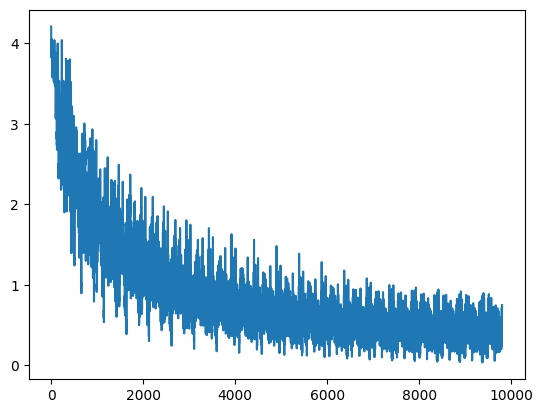

In [7]:
plt.plot(losses)

In [8]:
def generate_sample(rnn: RNN, length, start_text=' ', sampling_algo='greedy'):
    h = torch.zeros(1, rnn.hidden_size)
    start_text = torch.LongTensor([char_to_idx[char] for char in start_text]).view(1, -1)
    rnn.to('cpu')

    for i in range(len(start_text)):
        x = start_text[0, i].view(1, 1)
        y, h = rnn(x, h)

    for i in range(length):
        y, h = rnn(x, h)
        if sampling_algo=='greedy':
          x = torch.LongTensor([torch.argmax(y)])
        else:
          raise NotImplementedError()
        print(idx_to_char[x.item()], end="")

In [25]:
generate_sample(rnn, 20, start_text='TO')

ANO, Othello.
EMILIA

# LSTM
Now write the code for LSTM and train your own character level language models.

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size):
      super(LSTM, self).__init__()
      self.input_embed = nn.Embedding(vocab_size, input_size)
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size

      # gates: input, forget, cell, output
      self.xi = nn.Linear(input_size, hidden_size)


In [11]:
max_length = 10
n_epochs = 20
batch_size = 1
lr = 1e-4
optimizer = 'adam'
hidden_size = 500
lstm = LSTM(input_size=len(vocab),
          hidden_size=hidden_size,
          output_size=len(vocab),
          vocab_size = len(vocab))
lstm, losses = train(lstm,
                    corpus,
                    max_length,
                    n_epochs,
                    batch_size,
                    lr,
                    optimizer)

TypeError: LSTM.__init__() got an unexpected keyword argument 'input_size'

In [ ]:
generate_sample(lstm, length=500, start_text=' ')